In [1]:
# CKD Classification Model - Iterative Imputation Version
# This notebook uses IterativeImputer with Bayesian Ridge for missing value imputation
# instead of the class-based imputation method used in model_beta.ipynb

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import os

In [2]:
data_proforma_one = pd.read_excel("/Users/admin/Documents/CKD/data/proforma-records - LTH(OGBOMOSO) - 2018-11-22 08_49_39.xlsx")
data_proforma_two = pd.read_excel("/Users/admin/Documents/CKD/data/Edited proforma-records - LTH(OGBOMOSO) - 2019-01-12 08_02_20.xlsx")

In [3]:
data = pd.concat([data_proforma_one, data_proforma_two], ignore_index=True)
data.columns

Index(['S/N', 'Created At', 'Hospital', 'Patient Id', 'Age of Patient (year)',
       'Gender', 'Blood Pressure (mm/Hg)', 'Weight (kg)',
       'Body temperature (0^c)', 'Hemoglobin (mmol/L)', 'Glucose (mmol/L)',
       'Urea (mmol/L)', 'Creatinine (Umol/L)', 'Sodium (mmol/L)',
       'Calcium (mmol/L)', 'Potassium (mmol/L)', 'Protein Serum (g/dL)',
       'Albumin Serum (g/dL)', 'Phosphorus Serum (mmol/L)',
       'Serum Ferritin (ng/L)', 'Glomerular Filtration Rate (ml/min/1.73 m2)',
       'Intermediate laboratory report(s)',
       'Actual Diagnosed stage of the Acute and Chronic Kidney Disease',
       'Extra Information',
       'Treatment for this stage of the Acute and Chronic Kidney Disease',
       'Comorbidities', 'Date of first appointment',
       'Stage of ACKD at first appointment',
       'Level of education at first appointment',
       'Age of patient at first appointment',
       'Location of Patient at first appointment', 'Lifestyle of patient',
       'Circumstance

In [4]:
data.shape

(511, 33)

In [5]:
columns_with_lnull = ['Calcium (mmol/L)','Extra Information','Serum Ferritin (ng/L)','Phosphorus Serum (mmol/L)',
                      'Albumin Serum (g/dL)','Protein Serum (g/dL)','Hemoglobin (mmol/L)']

minerals_columns = ['Creatinine (Umol/L)', 'Sodium (mmol/L)', 'Potassium (mmol/L)',
                    'Glucose (mmol/L)', 'Urea (mmol/L)']

In [6]:
data =  data.drop(columns_with_lnull, axis=1)

for cols in minerals_columns:
  if data[cols].dtype == 'object':
    data[cols] = (
        data[cols]
        .astype(str)
        .replace(',', '.', regex=True)
        .astype(float)
    )
  else:
    print(f"Skipped {cols}")

Skipped Sodium (mmol/L)
Skipped Glucose (mmol/L)


In [7]:
data.dtypes

S/N                                                                   int64
Created At                                                           object
Hospital                                                             object
Patient Id                                                            int64
Age of Patient (year)                                               float64
Gender                                                               object
Blood Pressure (mm/Hg)                                               object
Weight (kg)                                                         float64
Body temperature (0^c)                                              float64
Glucose (mmol/L)                                                    float64
Urea (mmol/L)                                                       float64
Creatinine (Umol/L)                                                 float64
Sodium (mmol/L)                                                     float64
Potassium (m

In [8]:
for cols in minerals_columns:
  print("Group By against Actual Diagnosed stage of the Acute and Chronic Kidney Disease")
  print(data.groupby('Actual Diagnosed stage of the Acute and Chronic Kidney Disease')[cols].mean())
  print("|-----------------------------------------------------------------------------------------------------------------------|")
  print("\n")

Group By against Actual Diagnosed stage of the Acute and Chronic Kidney Disease
Actual Diagnosed stage of the Acute and Chronic Kidney Disease
GCF == 0, Undefined             738.21284
Stage 5 GFR <15mL/min/1.73m2    514.45480
Name: Creatinine (Umol/L), dtype: float64
|-----------------------------------------------------------------------------------------------------------------------|


Group By against Actual Diagnosed stage of the Acute and Chronic Kidney Disease
Actual Diagnosed stage of the Acute and Chronic Kidney Disease
GCF == 0, Undefined             130.159633
Stage 5 GFR <15mL/min/1.73m2    134.393182
Name: Sodium (mmol/L), dtype: float64
|-----------------------------------------------------------------------------------------------------------------------|


Group By against Actual Diagnosed stage of the Acute and Chronic Kidney Disease
Actual Diagnosed stage of the Acute and Chronic Kidney Disease
GCF == 0, Undefined             4.354488
Stage 5 GFR <15mL/min/1.73m2    

In [9]:
data['Comorbidities'] = data['Comorbidities'].str.title()

In [10]:
columns_for_modeling = ['Gender', 'Age of Patient (year)', 'Weight (kg)',
                        'Creatinine (Umol/L)', 'Sodium (mmol/L)', 'Potassium (mmol/L)',
                        'Glucose (mmol/L)', 'Urea (mmol/L)', 'Comorbidities',
                          'Actual Diagnosed stage of the Acute and Chronic Kidney Disease','Target'
                        ]

In [11]:
def clean_blood_pressure(df, column_name):
    """
    Cleans a blood pressure column in a DataFrame.
    
    - Removes trailing slashes
    - Handles missing or invalid values
    - Splits into Systolic (SBP) and Diastolic (DBP) columns
    - Converts to numeric format
    - Keeps the original column

    Args:
    - df (pd.DataFrame): The DataFrame containing the blood pressure column.
    - column_name (str): The column name of blood pressure readings.

    Returns:
    - pd.DataFrame: Updated DataFrame with 'SBP' and 'DBP' columns, keeping the original column.
    """
    # Ensure the column is a string type before processing
    df[column_name] = df[column_name].astype(str)

    # Remove trailing slashes
    df[column_name] = df[column_name].str.rstrip('/')

    # Replace standalone '/' or empty spaces with NaN
    df[column_name] = df[column_name].replace({'/': np.nan, '': np.nan})

    # Split into Systolic (SBP) and Diastolic (DBP) columns
    bp_df = df[column_name].str.split('/', expand=True)
    bp_df.columns = ['SBP', 'DBP']

    # Convert to numeric (invalid values become NaN)
    df['SBP'] = pd.to_numeric(bp_df['SBP'], errors='coerce')
    df['DBP'] = pd.to_numeric(bp_df['DBP'], errors='coerce')

    return df  # No dropping of the original column

data_clean_one = clean_blood_pressure(data, 'Blood Pressure (mm/Hg)')

In [12]:
def encode_kidney_disease_binary(df, column_name):
    """
    Converts the 'Actual Diagnosed stage of the Acute and Chronic Kidney Disease' column into a binary target variable.
    
    - Assigns 1 to "Stage 5 GFR <15mL/min/1.73m2"
    - Assigns 0 to "GCF == 0, Undefined"
    
    Args:
    - df (pd.DataFrame): The DataFrame containing the kidney disease stage column.
    - column_name (str): The column name to encode.

    Returns:
    - pd.DataFrame: Updated DataFrame with a binary target variable.
    """
    # Define binary mapping
    binary_mapping = {
        "Stage 5 GFR <15mL/min/1.73m2": 1,
        "GCF == 0, Undefined": 0
    }

    # Apply encoding
    df['Target'] = df[column_name].map(binary_mapping)

    return df

data_ = encode_kidney_disease_binary(data, 'Actual Diagnosed stage of the Acute and Chronic Kidney Disease')
data_['Target'].value_counts()


Target
1    300
0    211
Name: count, dtype: int64

In [13]:
data_.describe()

,S/N,Patient Id,Age of Patient (year),Weight (kg),Body temperature (0^c),Glucose (mmol/L),Urea (mmol/L),Creatinine (Umol/L),Sodium (mmol/L),Potassium (mmol/L),Glomerular Filtration Rate (ml/min/1.73 m2),Age of patient at first appointment,SBP,DBP,Target
count,511.000000,5.110000e+02,509.000000,308.000000,227.000000,221.000000,485.000000,481.000000,285.000000,329.000000,511.000000,492.000000,503.000000,503.000000,511.000000
mean,132.007828,1.111111e+09,47.756439,65.555260,36.452863,10.455023,22.369938,598.654811,132.774035,4.315258,0.263742,47.676829,148.304175,88.461233,0.587084
std,74.356006,7.761586e+01,18.876472,17.328311,7.377737,18.366039,22.426236,612.836969,9.221452,1.196067,0.616968,18.763488,33.751272,21.054709,0.492840
min,1.000000,1.111111e+09,0.013699,2.560000,-38.000000,2.400000,1.600000,1.582000,103.600000,1.100000,0.000000,5.000000,77.000000,10.000000,0.000000
25%,68.000000,1.111111e+09,34.000000,55.000000,36.400000,5.200000,8.200000,148.000000,128.000000,3.400000,0.000000,34.000000,120.000000,74.000000,0.000000
50%,132.000000,1.111111e+09,48.000000,64.000000,36.800000,7.100000,17.800000,326.000000,134.000000,4.100000,0.070101,48.000000,144.000000,86.000000,1.000000
75%,195.500000,1.111111e+09,63.000000,77.500000,37.300000,10.000000,30.000000,849.000000,138.000000,5.000000,0.289529,62.000000,168.000000,100.000000,1.000000
max,271.000000,1.111111e+09,85.000000,108.700000,59.400000,173.000000,219.000000,3300.000000,177.000000,8.000000,6.027917,85.000000,292.000000,160.000000,1.000000


In [14]:
data_['Actual Diagnosed stage of the Acute and Chronic Kidney Disease'].value_counts()

Actual Diagnosed stage of the Acute and Chronic Kidney Disease
Stage 5 GFR <15mL/min/1.73m2    300
GCF == 0, Undefined             211
Name: count, dtype: int64

In [15]:
data_['Gender'].value_counts()

Gender
Male      325
Female    186
Name: count, dtype: int64

In [16]:
data_[data_['Gender'] == 'Male']['Actual Diagnosed stage of the Acute and Chronic Kidney Disease'].value_counts()

Actual Diagnosed stage of the Acute and Chronic Kidney Disease
Stage 5 GFR <15mL/min/1.73m2    194
GCF == 0, Undefined             131
Name: count, dtype: int64

In [17]:
data_[data_['Gender'] == 'Female']['Actual Diagnosed stage of the Acute and Chronic Kidney Disease'].value_counts()

Actual Diagnosed stage of the Acute and Chronic Kidney Disease
Stage 5 GFR <15mL/min/1.73m2    106
GCF == 0, Undefined              80
Name: count, dtype: int64

In [18]:
data_.groupby('Actual Diagnosed stage of the Acute and Chronic Kidney Disease')['Age of Patient (year)'].mean()

Actual Diagnosed stage of the Acute and Chronic Kidney Disease
GCF == 0, Undefined             46.803828
Stage 5 GFR <15mL/min/1.73m2    48.420091
Name: Age of Patient (year), dtype: float64

In [19]:
# group by the Actual Diagnosed star of acute and ckd to the average weight on both sides
data_.groupby('Actual Diagnosed stage of the Acute and Chronic Kidney Disease')['Weight (kg)'].mean()

Actual Diagnosed stage of the Acute and Chronic Kidney Disease
GCF == 0, Undefined             74.2500
Stage 5 GFR <15mL/min/1.73m2    65.3234
Name: Weight (kg), dtype: float64

Text(0.5, 0, 'Kidney Disease Stage')

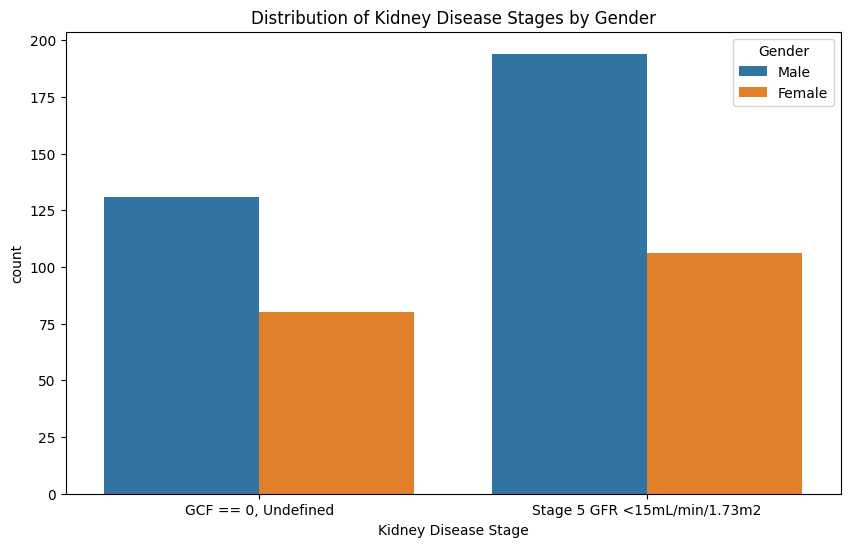

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Actual Diagnosed stage of the Acute and Chronic Kidney Disease', hue='Gender', data=data_)
plt.title('Distribution of Kidney Disease Stages by Gender')
plt.xlabel('Kidney Disease Stage')

<Figure size 1200x1000 with 0 Axes>

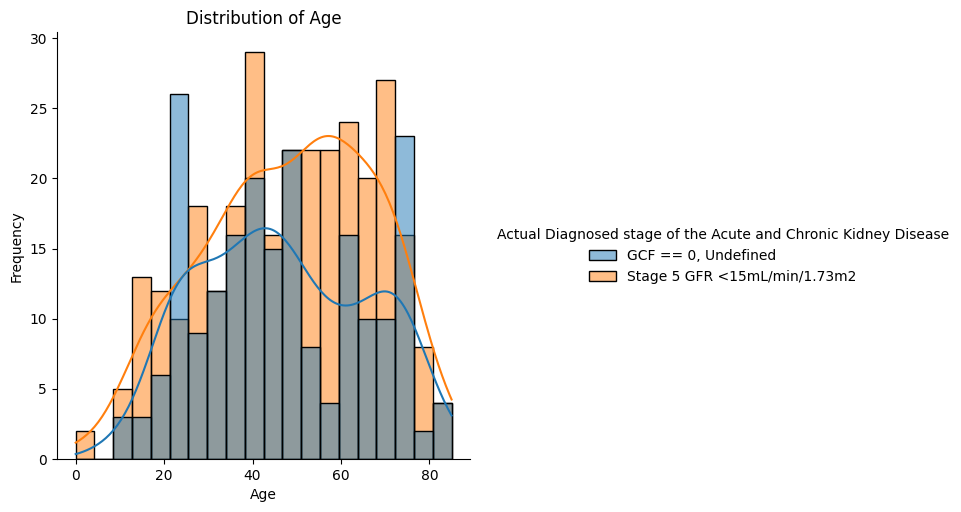

In [21]:
plt.figure(figsize=(12,10))
sns.displot(data=data_, x='Age of Patient (year)', hue='Actual Diagnosed stage of the Acute and Chronic Kidney Disease',bins=20, kde=True) # Changed this line
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

<Figure size 1200x1000 with 0 Axes>

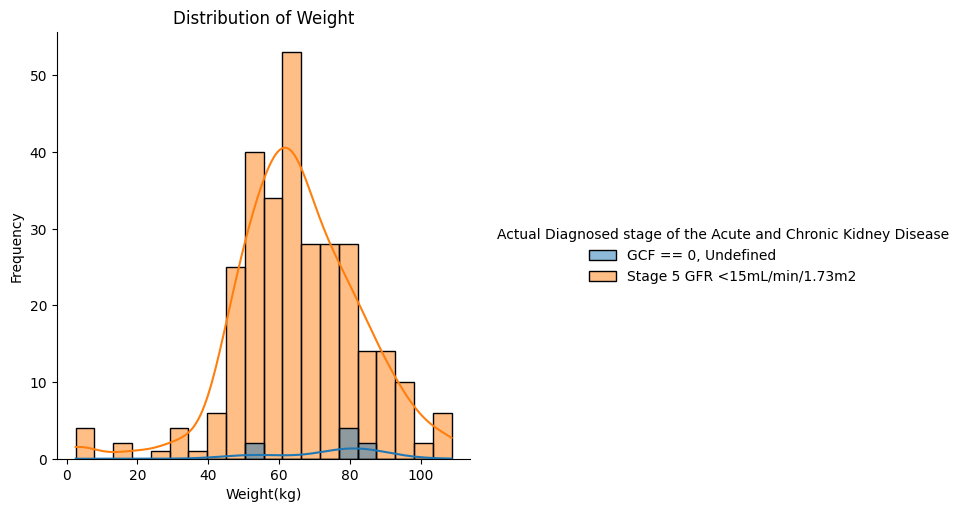

In [22]:
plt.figure(figsize=(12,10))
sns.displot(data=data_, x='Weight (kg)', hue='Actual Diagnosed stage of the Acute and Chronic Kidney Disease',bins=20, kde=True) # Changed this line
plt.title('Distribution of Weight')
plt.xlabel('Weight(kg)')
plt.ylabel('Frequency')
plt.show()

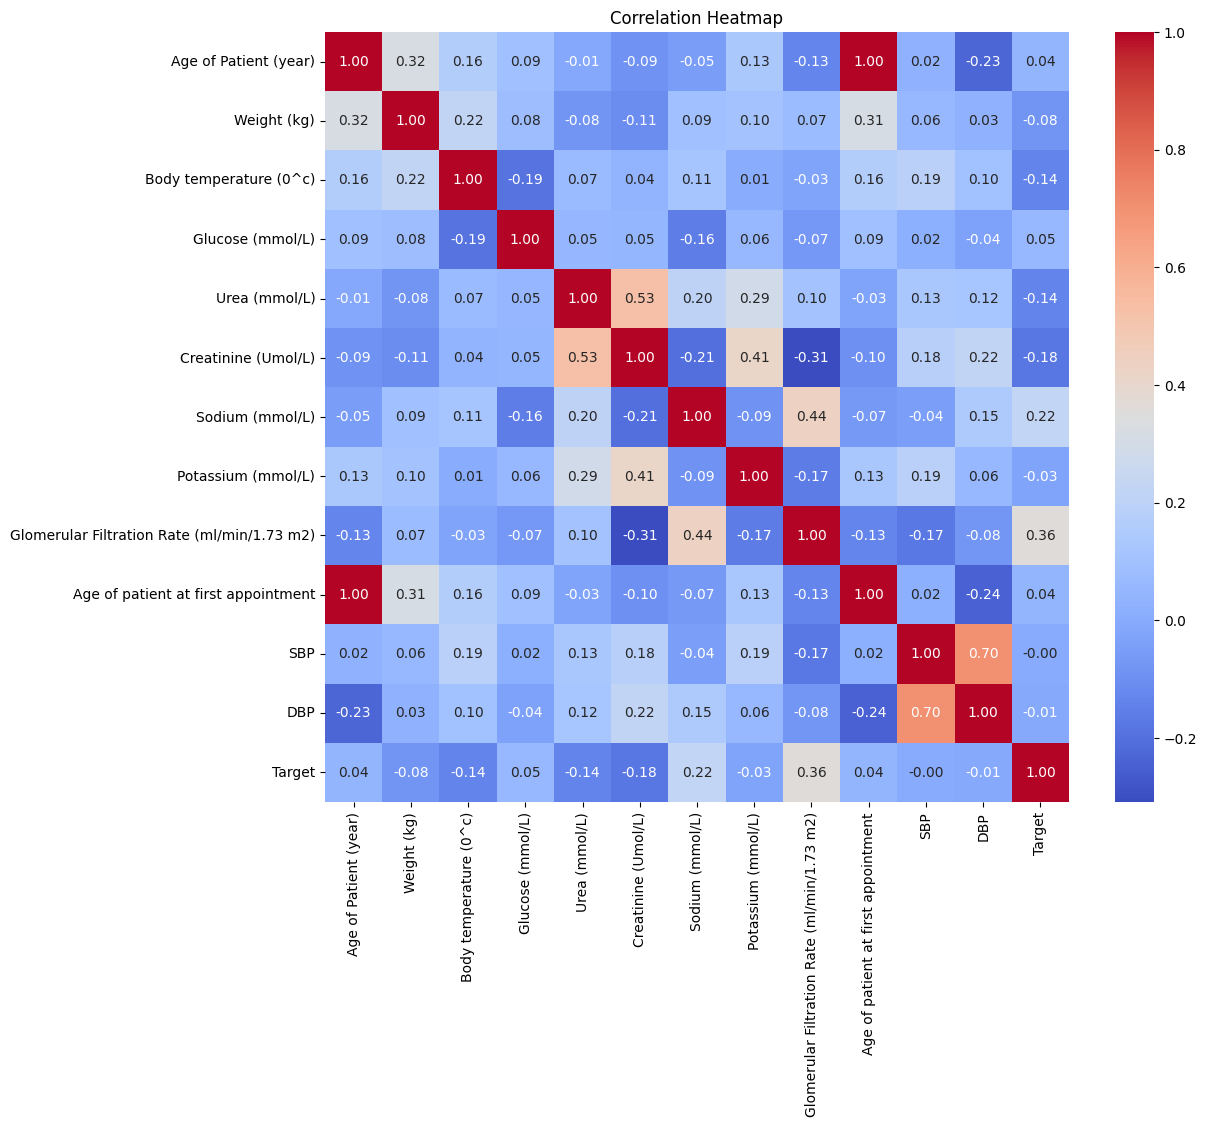

In [23]:
numerical_columns = data_.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('S/N')
numerical_columns.remove('Patient Id')

correlation_table = data_[numerical_columns].corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

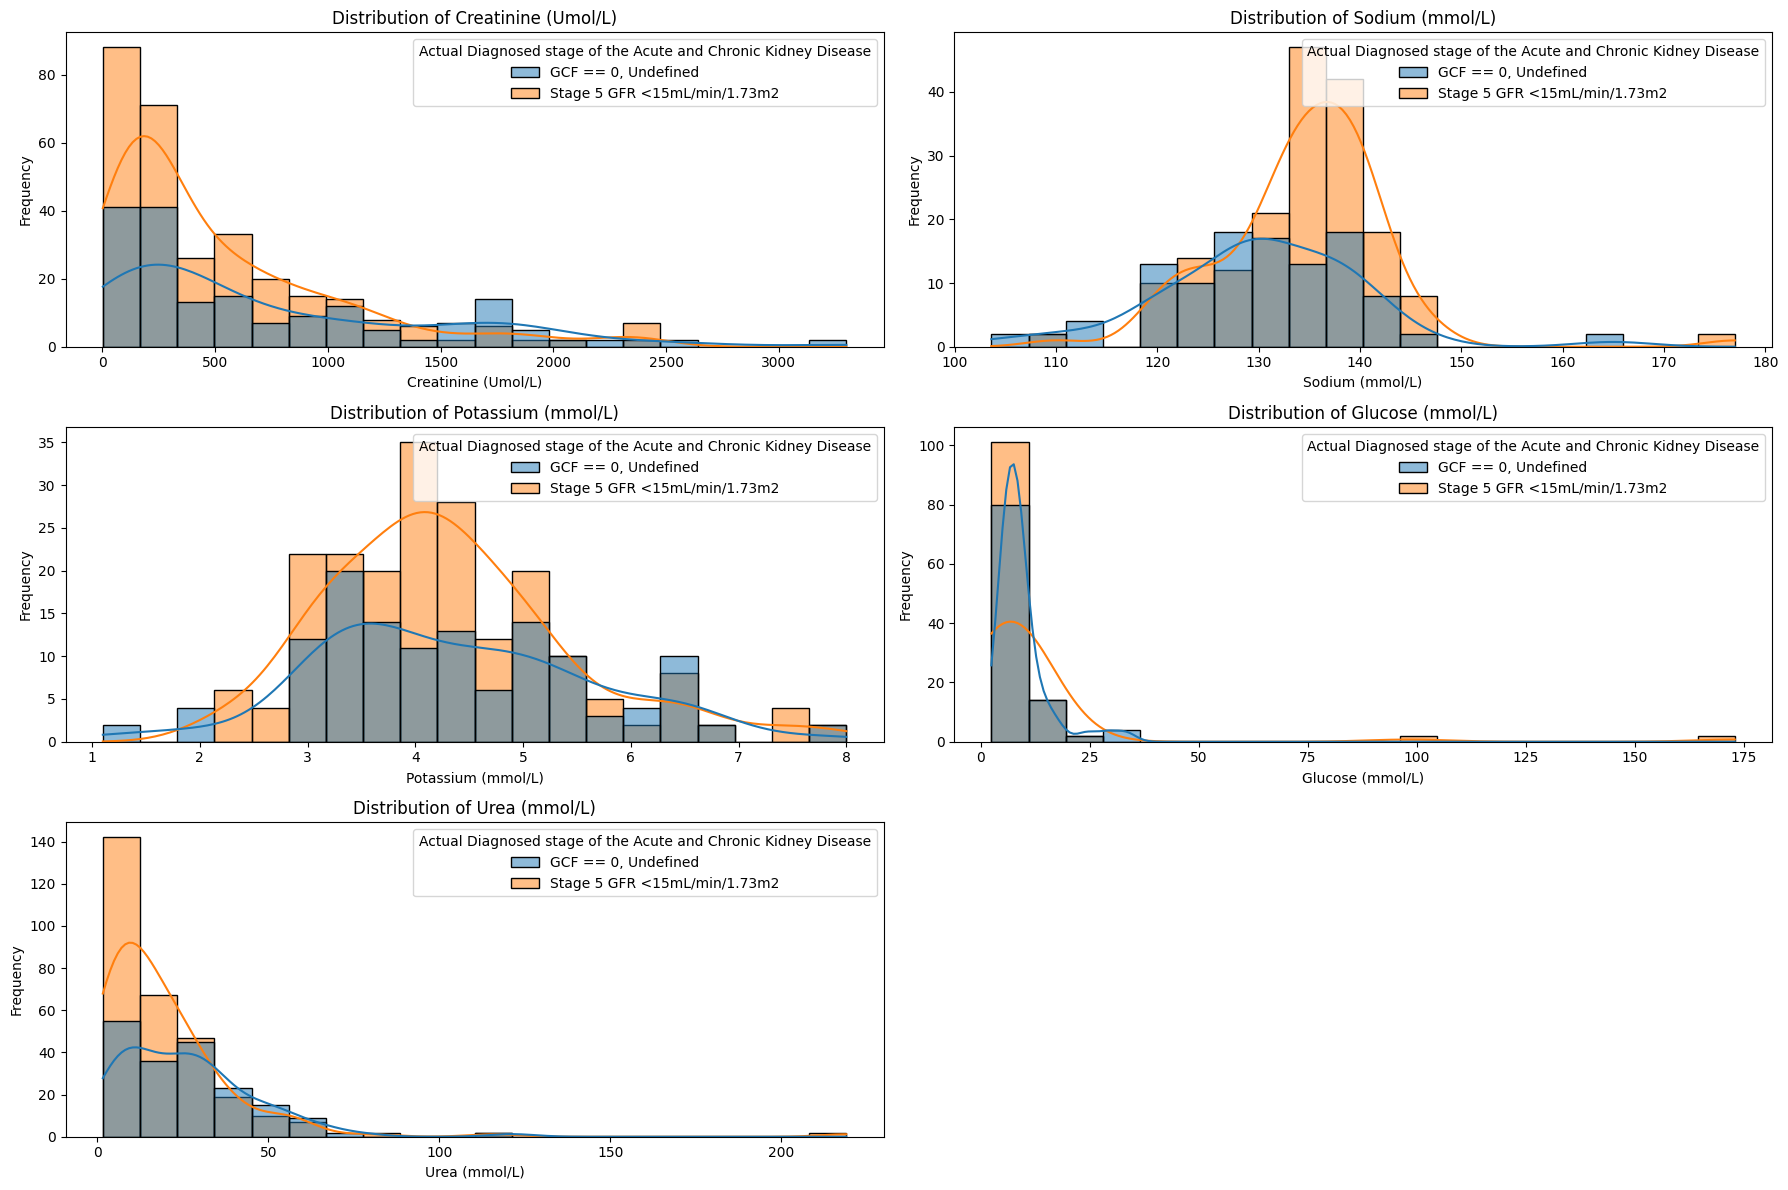

In [24]:
fig, axes = plt.subplots(nrows=(len(minerals_columns) + 1) // 2, ncols=2, figsize=(18, 12)) 
axes = axes.flatten()

# Loop over the mineral columns and generate a plot for each
for idx, col in enumerate(minerals_columns):
    sns.histplot(data=data_, x=col, hue='Actual Diagnosed stage of the Acute and Chronic Kidney Disease',
                 bins=20, kde=True, ax=axes[idx]) 
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

for idx in range(len(minerals_columns), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [25]:
data_.isnull().sum().sort_values(ascending=False)

Glucose (mmol/L)                                                    290
Body temperature (0^c)                                              284
Sodium (mmol/L)                                                     226
Weight (kg)                                                         203
Potassium (mmol/L)                                                  182
Intermediate laboratory report(s)                                   111
Level of education at first appointment                              43
Creatinine (Umol/L)                                                  30
Urea (mmol/L)                                                        26
Comorbidities                                                        26
Circumstances surrounding first appointment                          20
Age of patient at first appointment                                  19
Treatment for this stage of the Acute and Chronic Kidney Disease     14
Lifestyle of patient                                            

In [26]:
def iterative_bayesian_imputation(df, target_column, exclude_columns=None, max_iter=10, random_state=42):
    """
    Advanced iterative imputation using Bayesian Ridge regression to predict missing values.
    This method uses relationships between features to make more accurate imputations.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data with missing values
    target_column : str
        Name of the target column (will be excluded from imputation to avoid leakage)
    exclude_columns : list or None
        Additional columns to exclude from imputation (e.g., IDs, categorical columns)
    max_iter : int, default 10
        Maximum number of imputation rounds
    random_state : int, default 42
        Random state for reproducibility
    
    Returns:
    --------
    pd.DataFrame: DataFrame with imputed values
    dict: Imputation statistics and information
    """
    
    from sklearn.experimental import enable_iterative_imputer  # noqa
    from sklearn.impute import IterativeImputer
    from sklearn.linear_model import BayesianRidge
    
    print("="*80)
    print("ITERATIVE BAYESIAN RIDGE IMPUTATION")
    print("="*80)
    
    df_working = df.copy()
    
    # Identify columns to exclude from imputation
    exclude_cols = [target_column] if target_column else []
    if exclude_columns:
        exclude_cols.extend(exclude_columns)
    
    # Get all numeric columns for imputation
    numeric_cols = df_working.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove excluded columns
    for col in exclude_cols:
        if col in numeric_cols:
            numeric_cols.remove(col)
    
    print(f"📊 Columns to be imputed: {len(numeric_cols)}")
    for i, col in enumerate(numeric_cols, 1):
        missing_count = df_working[col].isnull().sum()
        missing_pct = (missing_count / len(df_working)) * 100
        print(f"  {i:2d}. {col}: {missing_count} missing ({missing_pct:.1f}%)")
    
    # Prepare features for imputation (exclude target and specified columns)
    features_for_imputation = df_working[numeric_cols]
    
    print(f"\n🔧 Configuring Iterative Imputer:")
    print(f"   • Estimator: Bayesian Ridge Regression")
    print(f"   • Max iterations: {max_iter}")
    print(f"   • Random state: {random_state}")
    
    # Create the iterative imputer with Bayesian Ridge estimator
    imputer = IterativeImputer(
        estimator=BayesianRidge(),  # Advanced regression estimator
        max_iter=max_iter,          # Number of imputation rounds
        random_state=random_state,
        verbose=1                   # Show progress
    )
    
    print(f"\n⚙️  Starting iterative imputation process...")
    
    # Fit and transform the features
    imputed_array = imputer.fit_transform(features_for_imputation)
    
    # Convert back to DataFrame with original column names
    df_imputed_features = pd.DataFrame(imputed_array, 
                                      columns=features_for_imputation.columns,
                                      index=features_for_imputation.index)
    
    # Create the final imputed DataFrame
    df_imputed = df_working.copy()
    
    # Replace the imputed columns in the original DataFrame
    for col in numeric_cols:
        df_imputed[col] = df_imputed_features[col]
    
    # Ensure non-negative values for medical measurements
    medical_cols = [col for col in numeric_cols if any(keyword in col.lower() 
                   for keyword in ['creatinine', 'sodium', 'potassium', 'glucose', 'urea', 'weight', 'age'])]
    
    for col in medical_cols:
        df_imputed[col] = np.maximum(df_imputed[col], 0.1)
    
    print(f"✅ Iterative imputation completed!")
    print(f"🏥 Applied non-negative constraints to {len(medical_cols)} medical measurements")
    
    # Calculate imputation statistics
    imputation_stats = {
        'method': 'Iterative Bayesian Ridge',
        'max_iterations': max_iter,
        'columns_imputed': numeric_cols,
        'total_missing_before': df_working[numeric_cols].isnull().sum().sum(),
        'total_missing_after': df_imputed[numeric_cols].isnull().sum().sum(),
        'estimator': 'Bayesian Ridge Regression',
        'feature_relationships': 'Used inter-feature correlations for imputation'
    }
    
    return df_imputed, imputation_stats


def analyze_iterative_imputation_quality(original_df, imputed_df, target_column=None):
    """
    Analyze the quality of iterative imputation by comparing distributions 
    and examining imputation effectiveness.
    
    Parameters:
    -----------
    original_df : pd.DataFrame
        Original DataFrame with missing values
    imputed_df : pd.DataFrame  
        DataFrame after iterative imputation
    target_column : str or None
        Target column name for class-based analysis
    """
    
    print("\n" + "="*80)
    print("ITERATIVE IMPUTATION QUALITY ANALYSIS")
    print("="*80)
    
    # Get numeric columns that had missing values
    numeric_cols = original_df.select_dtypes(include=[np.number]).columns
    missing_cols = [col for col in numeric_cols if original_df[col].isnull().sum() > 0]
    
    if target_column and target_column in missing_cols:
        missing_cols.remove(target_column)
    
    print(f"📊 Analyzing {len(missing_cols)} columns that had missing values:\n")
    
    for col in missing_cols:
        missing_count = original_df[col].isnull().sum()
        if missing_count == 0:
            continue
            
        print(f"Column: {col}")
        print("-" * 60)
        
        # Overall statistics comparison
        orig_data = original_df[col].dropna()
        imputed_data = imputed_df[col]
        
        print(f"  📈 Overall Statistics:")
        print(f"     Original  - Mean: {orig_data.mean():.3f}, Median: {orig_data.median():.3f}, Std: {orig_data.std():.3f}")
        print(f"     Imputed   - Mean: {imputed_data.mean():.3f}, Median: {imputed_data.median():.3f}, Std: {imputed_data.std():.3f}")
        print(f"     Missing values filled: {missing_count} ({(missing_count/len(original_df)*100):.1f}%)")
        
        # Class-based analysis if target column is provided
        if target_column and target_column in original_df.columns:
            print(f"\n  🎯 Class-based Analysis (by {target_column}):")
            
            for target_class in original_df[target_column].unique():
                if pd.isna(target_class):
                    continue
                    
                class_mask = (original_df[target_column] == target_class)
                
                # Original statistics (excluding missing values)
                orig_class_data = original_df[class_mask][col].dropna()
                imputed_class_data = imputed_df[class_mask][col]
                
                if len(orig_class_data) == 0:
                    continue
                
                missing_in_class = class_mask.sum() - len(orig_class_data)
                
                print(f"     Class '{target_class}':")
                print(f"       Original - Mean: {orig_class_data.mean():.3f}, Std: {orig_class_data.std():.3f}")
                print(f"       Imputed  - Mean: {imputed_class_data.mean():.3f}, Std: {imputed_class_data.std():.3f}")
                print(f"       Filled: {missing_in_class} values")
        
        print("\n")
    
    print("="*80)
    print("✨ ITERATIVE IMPUTATION ADVANTAGES:")
    print("   • Uses relationships between all features for imputation")
    print("   • Bayesian Ridge handles multicollinearity well") 
    print("   • Iterative process refines estimates over multiple rounds")
    print("   • More sophisticated than simple statistical imputation")
    print("="*80)

In [27]:
# Apply the iterative Bayesian Ridge imputation
# Note: We exclude categorical columns and target-related columns from imputation
exclude_columns = ['S/N', 'Patient Id', 'Comorbidities', 'Gender']  # Categorical/ID columns

data_imputed, imputation_stats = iterative_bayesian_imputation(
    df=data_, 
    target_column='Actual Diagnosed stage of the Acute and Chronic Kidney Disease',
    exclude_columns=exclude_columns,
    max_iter=10,  # Number of iterative imputation rounds
    random_state=42
)

# Check missing values after imputation
print("\n" + "="*60)
print("MISSING VALUES AFTER ITERATIVE IMPUTATION")
print("="*60)
missing_after = data_imputed.isnull().sum().sort_values(ascending=False)
print(missing_after[missing_after > 0])
if missing_after.sum() == 0:
    print("✅ No missing values remaining!")
else:
    print(f"⚠️  {missing_after.sum()} missing values still remain")

ITERATIVE BAYESIAN RIDGE IMPUTATION
📊 Columns to be imputed: 13
   1. Age of Patient (year): 2 missing (0.4%)
   2. Weight (kg): 203 missing (39.7%)
   3. Body temperature (0^c): 284 missing (55.6%)
   4. Glucose (mmol/L): 290 missing (56.8%)
   5. Urea (mmol/L): 26 missing (5.1%)
   6. Creatinine (Umol/L): 30 missing (5.9%)
   7. Sodium (mmol/L): 226 missing (44.2%)
   8. Potassium (mmol/L): 182 missing (35.6%)
   9. Glomerular Filtration Rate (ml/min/1.73 m2): 0 missing (0.0%)
  10. Age of patient at first appointment: 19 missing (3.7%)
  11. SBP: 8 missing (1.6%)
  12. DBP: 8 missing (1.6%)
  13. Target: 0 missing (0.0%)

🔧 Configuring Iterative Imputer:
   • Estimator: Bayesian Ridge Regression
   • Max iterations: 10
   • Random state: 42

⚙️  Starting iterative imputation process...
[IterativeImputer] Completing matrix with shape (511, 13)
[IterativeImputer] Change: 603.4867913040835, scaled tolerance: 3.3000000000000003 
[IterativeImputer] Change: 103.84648127469342, scaled tole

/Users/admin/Documents/CKD/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [28]:
# Analyze the quality of the iterative imputation
analyze_iterative_imputation_quality(data_, data_imputed, 'Actual Diagnosed stage of the Acute and Chronic Kidney Disease')

# Display imputation method information
print("\n" + "="*80)
print("ITERATIVE IMPUTATION METHOD DETAILS")
print("="*80)

print(f"Method: {imputation_stats['method']}")
print(f"Estimator: {imputation_stats['estimator']}")
print(f"Max Iterations: {imputation_stats['max_iterations']}")
print(f"Total Missing Values Before: {imputation_stats['total_missing_before']}")
print(f"Total Missing Values After: {imputation_stats['total_missing_after']}")
print(f"Columns Imputed: {len(imputation_stats['columns_imputed'])}")

print(f"\n📋 Columns that underwent iterative imputation:")
for i, col in enumerate(imputation_stats['columns_imputed'], 1):
    print(f"  {i:2d}. {col}")

print(f"\n🧠 Key Advantage: {imputation_stats['feature_relationships']}")


ITERATIVE IMPUTATION QUALITY ANALYSIS
📊 Analyzing 11 columns that had missing values:

Column: Age of Patient (year)
------------------------------------------------------------
  📈 Overall Statistics:
     Original  - Mean: 47.756, Median: 48.000, Std: 18.876
     Imputed   - Mean: 47.734, Median: 48.000, Std: 18.842
     Missing values filled: 2 (0.4%)

  🎯 Class-based Analysis (by Actual Diagnosed stage of the Acute and Chronic Kidney Disease):
     Class 'GCF == 0, Undefined':
       Original - Mean: 46.804, Std: 18.689
       Imputed  - Mean: 46.757, Std: 18.606
       Filled: 2 values
     Class 'Stage 5 GFR <15mL/min/1.73m2':
       Original - Mean: 48.420, Std: 19.009
       Imputed  - Mean: 48.421, Std: 19.007
       Filled: 0 values


Column: Weight (kg)
------------------------------------------------------------
  📈 Overall Statistics:
     Original  - Mean: 65.555, Median: 64.000, Std: 17.328
     Imputed   - Mean: 63.945, Median: 63.000, Std: 16.401
     Missing values f

In [29]:
data_imputed.isnull().sum().sort_values(ascending=False)

Intermediate laboratory report(s)                                   111
Level of education at first appointment                              43
Comorbidities                                                        26
Circumstances surrounding first appointment                          20
Treatment for this stage of the Acute and Chronic Kidney Disease     14
Lifestyle of patient                                                 10
Date of first appointment                                            10
Blood Pressure (mm/Hg)                                                8
Location of Patient at first appointment                              8
S/N                                                                   0
DBP                                                                   0
SBP                                                                   0
Age of patient at first appointment                                   0
Stage of ACKD at first appointment                              

In [30]:
data_modelling = data_imputed[columns_for_modeling]
data_modelling.isnull().sum().sort_values(ascending=False)

Comorbidities                                                     26
Gender                                                             0
Age of Patient (year)                                              0
Weight (kg)                                                        0
Creatinine (Umol/L)                                                0
Sodium (mmol/L)                                                    0
Potassium (mmol/L)                                                 0
Glucose (mmol/L)                                                   0
Urea (mmol/L)                                                      0
Actual Diagnosed stage of the Acute and Chronic Kidney Disease     0
Target                                                             0
dtype: int64

In [31]:
data_modelling.head()

,Gender,Age of Patient (year),Weight (kg),Creatinine (Umol/L),Sodium (mmol/L),Potassium (mmol/L),Glucose (mmol/L),Urea (mmol/L),Comorbidities,Actual Diagnosed stage of the Acute and Chronic Kidney Disease,Target
0,Male,74.0,107.549655,131.0,115.689174,6.032161,33.300000,14.0,Dm Nephropathy,"GCF == 0, Undefined",0.0
1,Male,60.0,69.127363,140.0,132.391230,3.863440,10.868480,6.8,NaN,"GCF == 0, Undefined",0.0
2,Male,73.0,51.000000,677.0,126.802444,5.266824,8.600000,38.3,Hypertension,Stage 5 GFR <15mL/min/1.73m2,1.0
3,Female,22.0,58.008719,93.0,130.000000,3.200000,9.011719,2.5,NaN,"GCF == 0, Undefined",0.0
4,Male,69.0,94.000000,116.0,138.032702,3.676448,15.135427,2.6,Hypertension,Stage 5 GFR <15mL/min/1.73m2,1.0


In [32]:
data_modelling.dtypes

Gender                                                             object
Age of Patient (year)                                             float64
Weight (kg)                                                       float64
Creatinine (Umol/L)                                               float64
Sodium (mmol/L)                                                   float64
Potassium (mmol/L)                                                float64
Glucose (mmol/L)                                                  float64
Urea (mmol/L)                                                     float64
Comorbidities                                                      object
Actual Diagnosed stage of the Acute and Chronic Kidney Disease     object
Target                                                            float64
dtype: object

In [33]:
# Prepare data for modeling
# Drop columns that won't be used as features
columns_to_drop = ['Comorbidities', 'Actual Diagnosed stage of the Acute and Chronic Kidney Disease']

# Create feature matrix X and target vector y
X = data_modelling.drop(columns_to_drop + ['Target'], axis=1)
y = data_modelling['Target']

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)
print("\nFeature columns:")
print(X.columns.tolist())
print("\nTarget distribution:")
print(y.value_counts())

Features (X) shape: (511, 8)
Target (y) shape: (511,)

Feature columns:
['Gender', 'Age of Patient (year)', 'Weight (kg)', 'Creatinine (Umol/L)', 'Sodium (mmol/L)', 'Potassium (mmol/L)', 'Glucose (mmol/L)', 'Urea (mmol/L)']

Target distribution:
Target
1.0    300
0.0    211
Name: count, dtype: int64


In [34]:
# Apply one-hot encoding to Gender column
X_encoded = pd.get_dummies(X, columns=['Gender'], prefix='Gender', drop_first=True)

print("Shape after one-hot encoding:", X_encoded.shape)
print("\nColumns after encoding:")
print(X_encoded.columns.tolist())
print("\nData types:")
print(X_encoded.dtypes)

Shape after one-hot encoding: (511, 8)

Columns after encoding:
['Age of Patient (year)', 'Weight (kg)', 'Creatinine (Umol/L)', 'Sodium (mmol/L)', 'Potassium (mmol/L)', 'Glucose (mmol/L)', 'Urea (mmol/L)', 'Gender_Male']

Data types:
Age of Patient (year)    float64
Weight (kg)              float64
Creatinine (Umol/L)      float64
Sodium (mmol/L)          float64
Potassium (mmol/L)       float64
Glucose (mmol/L)         float64
Urea (mmol/L)            float64
Gender_Male                 bool
dtype: object


In [35]:
# Final check - ensure no missing values in features
print("Missing values in X_encoded:")
print(X_encoded.isnull().sum().sort_values(ascending=False))
print("\nMissing values in y:")
print(y.isnull().sum())

# Display sample of the prepared data
print("\nSample of prepared features (X_encoded):")
print(X_encoded.head())
print("\nSample of target variable (y):")
print(y.head())

Missing values in X_encoded:
Age of Patient (year)    0
Weight (kg)              0
Creatinine (Umol/L)      0
Sodium (mmol/L)          0
Potassium (mmol/L)       0
Glucose (mmol/L)         0
Urea (mmol/L)            0
Gender_Male              0
dtype: int64

Missing values in y:
0

Sample of prepared features (X_encoded):
   Age of Patient (year)  Weight (kg)  Creatinine (Umol/L)  Sodium (mmol/L)  \
0                   74.0   107.549655                131.0       115.689174   
1                   60.0    69.127363                140.0       132.391230   
2                   73.0    51.000000                677.0       126.802444   
3                   22.0    58.008719                 93.0       130.000000   
4                   69.0    94.000000                116.0       138.032702   

   Potassium (mmol/L)  Glucose (mmol/L)  Urea (mmol/L)  Gender_Male  
0            6.032161         33.300000           14.0         True  
1            3.863440         10.868480            6.8       

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintains the same proportion of classes in train/test
)

print("Training set shape:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print("\nTesting set shape:")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True))

Training set shape:
X_train: (408, 8)
y_train: (408,)

Testing set shape:
X_test: (103, 8)
y_test: (103,)

Class distribution in training set:
Target
1.0    0.588235
0.0    0.411765
Name: proportion, dtype: float64

Class distribution in testing set:
Target
1.0    0.582524
0.0    0.417476
Name: proportion, dtype: float64


In [37]:
# Create a preprocessing pipeline for scaling numerical features
from sklearn.preprocessing import StandardScaler

# Identify numerical columns (all except the encoded gender column)
numerical_features = [col for col in X_encoded.columns if not col.startswith('Gender_')]
print("Numerical features to be scaled:")
print(numerical_features)

# Create and fit the scaler on training data
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only the numerical features
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("\nScaling completed!")
print("Training set statistics after scaling (numerical features only):")
print(X_train_scaled[numerical_features].describe())

Numerical features to be scaled:
['Age of Patient (year)', 'Weight (kg)', 'Creatinine (Umol/L)', 'Sodium (mmol/L)', 'Potassium (mmol/L)', 'Glucose (mmol/L)', 'Urea (mmol/L)']

Scaling completed!
Training set statistics after scaling (numerical features only):
       Age of Patient (year)   Weight (kg)  Creatinine (Umol/L)  \
count           4.080000e+02  4.080000e+02         4.080000e+02   
mean            1.480297e-16  2.111601e-16        -6.095342e-17   
std             1.001228e+00  1.001228e+00         1.001228e+00   
min            -2.540210e+00 -3.781840e+00        -9.952363e-01   
25%            -8.104136e-01 -5.658474e-01        -7.584669e-01   
50%             1.034911e-01 -1.011403e-01        -4.097656e-01   
75%             8.054759e-01  5.380403e-01         4.405865e-01   
max             1.957790e+00  2.892058e+00         4.677575e+00   

       Sodium (mmol/L)  Potassium (mmol/L)  Glucose (mmol/L)  Urea (mmol/L)  
count     4.080000e+02        4.080000e+02      4.080000e+

In [38]:
# Import additional libraries for machine learning models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [39]:
# Dictionary to store all models and their results
models_results = {}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """
    Evaluate a trained model and store results
    """
    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Probabilities (for AUC calculation)
    if hasattr(model, "predict_proba"):
        test_proba = model.predict_proba(X_test)[:, 1]
        train_proba = model.predict_proba(X_train)[:, 1]
    else:
        test_proba = model.decision_function(X_test)
        train_proba = model.decision_function(X_train)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    train_auc = roc_auc_score(y_train, train_proba)
    test_auc = roc_auc_score(y_test, test_proba)
    
    # Store results
    models_results[name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'test_predictions': test_pred,
        'test_probabilities': test_proba
    }
    
    print(f"\n{name} Results:")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Train AUC: {train_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    
    return model

print("Evaluation function defined!")

Evaluation function defined!


In [40]:
# 1. Random Forest Classifier
print("="*60)
print("TRAINING RANDOM FOREST CLASSIFIER")
print("="*60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
evaluate_model("Random Forest", rf_model, X_train_scaled, X_test_scaled, y_train, y_test)

TRAINING RANDOM FOREST CLASSIFIER

Random Forest Results:
Train Accuracy: 0.9975
Test Accuracy: 0.9126
Train AUC: 1.0000
Test AUC: 0.9279

Random Forest Results:
Train Accuracy: 0.9975
Test Accuracy: 0.9126
Train AUC: 1.0000
Test AUC: 0.9279


RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_jobs=-1, random_state=42)

In [41]:
# 2. XGBoost Classifier
print("="*60)
print("TRAINING XGBOOST CLASSIFIER")
print("="*60)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_scaled, y_train)
evaluate_model("XGBoost", xgb_model, X_train_scaled, X_test_scaled, y_train, y_test)

TRAINING XGBOOST CLASSIFIER

XGBoost Results:
Train Accuracy: 1.0000
Test Accuracy: 0.9223
Train AUC: 1.0000
Test AUC: 0.9012

XGBoost Results:
Train Accuracy: 1.0000
Test Accuracy: 0.9223
Train AUC: 1.0000
Test AUC: 0.9012


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [42]:
# 3. Support Vector Machine (SVM)
print("="*60)
print("TRAINING SUPPORT VECTOR MACHINE")
print("="*60)

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

svm_model.fit(X_train_scaled, y_train)
evaluate_model("SVM", svm_model, X_train_scaled, X_test_scaled, y_train, y_test)

TRAINING SUPPORT VECTOR MACHINE

SVM Results:
Train Accuracy: 0.7083
Test Accuracy: 0.6602
Train AUC: 0.8153
Test AUC: 0.7341


SVC(probability=True, random_state=42)

In [43]:
# 4. CatBoost Classifier
print("="*60)
print("TRAINING CATBOOST CLASSIFIER")
print("="*60)

cat_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=False
)

cat_model.fit(X_train_scaled, y_train)
evaluate_model("CatBoost", cat_model, X_train_scaled, X_test_scaled, y_train, y_test)

TRAINING CATBOOST CLASSIFIER

CatBoost Results:
Train Accuracy: 0.9779
Test Accuracy: 0.8544
Train AUC: 0.9989
Test AUC: 0.9019


In [44]:
# 5. AdaBoost Classifier
print("="*60)
print("TRAINING ADABOOST CLASSIFIER")
print("="*60)

ada_model = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

ada_model.fit(X_train_scaled, y_train)
evaluate_model("AdaBoost", ada_model, X_train_scaled, X_test_scaled, y_train, y_test)

TRAINING ADABOOST CLASSIFIER

AdaBoost Results:
Train Accuracy: 0.8358
Test Accuracy: 0.7670
Train AUC: 0.9213
Test AUC: 0.8118


AdaBoostClassifier(n_estimators=100, random_state=42)

In [45]:
# 6. Feedforward Neural Network with Adam Optimizer (MLPClassifier)
print("="*60)
print("TRAINING NEURAL NETWORK (ADAM OPTIMIZER)")
print("="*60)

fnn_adam_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10
)

fnn_adam_model.fit(X_train_scaled, y_train)
evaluate_model("FNN (Adam)", fnn_adam_model, X_train_scaled, X_test_scaled, y_train, y_test)

TRAINING NEURAL NETWORK (ADAM OPTIMIZER)

FNN (Adam) Results:
Train Accuracy: 0.6078
Test Accuracy: 0.6117
Train AUC: 0.6846
Test AUC: 0.6984


MLPClassifier(early_stopping=True, hidden_layer_sizes=(128, 64, 32),
              max_iter=1000, random_state=42, validation_fraction=0.2)

In [46]:
# Skip this cell - not needed anymore as we're using MLPClassifier

In [47]:
# 7. Feedforward Neural Network with SGD Optimizer (MLPClassifier)
print("="*60)
print("TRAINING NEURAL NETWORK (SGD OPTIMIZER)")
print("="*60)

fnn_sgd_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='sgd',
    learning_rate_init=0.01,
    momentum=0.9,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10
)

fnn_sgd_model.fit(X_train_scaled, y_train)
evaluate_model("FNN (SGD)", fnn_sgd_model, X_train_scaled, X_test_scaled, y_train, y_test)

print("\nAll models trained successfully!")

TRAINING NEURAL NETWORK (SGD OPTIMIZER)

FNN (SGD) Results:
Train Accuracy: 0.5882
Test Accuracy: 0.5825
Train AUC: 0.4621
Test AUC: 0.4748

All models trained successfully!


In [48]:
# Model Comparison and Results Summary
print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

# Create a comparison DataFrame
results_df = pd.DataFrame({
    'Model': list(models_results.keys()),
    'Train_Accuracy': [models_results[model]['train_accuracy'] for model in models_results.keys()],
    'Test_Accuracy': [models_results[model]['test_accuracy'] for model in models_results.keys()],
    'Train_AUC': [models_results[model]['train_auc'] for model in models_results.keys()],
    'Test_AUC': [models_results[model]['test_auc'] for model in models_results.keys()]
})

# Sort by test accuracy
results_df = results_df.sort_values('Test_Accuracy', ascending=False)
results_df = results_df.reset_index(drop=True)

print("\nModel Performance Summary (Sorted by Test Accuracy):")
print("-" * 80)
for idx, row in results_df.iterrows():
    print(f"{idx+1:2d}. {row['Model']:<15} | "
          f"Test Acc: {row['Test_Accuracy']:.4f} | "
          f"Test AUC: {row['Test_AUC']:.4f} | "
          f"Train Acc: {row['Train_Accuracy']:.4f}")

print(f"\nBest performing model: {results_df.iloc[0]['Model']} "
      f"with Test Accuracy: {results_df.iloc[0]['Test_Accuracy']:.4f}")

# Display the full results table
print("\nDetailed Results Table:")
print(results_df.round(4))

MODEL PERFORMANCE COMPARISON

Model Performance Summary (Sorted by Test Accuracy):
--------------------------------------------------------------------------------
 1. XGBoost         | Test Acc: 0.9223 | Test AUC: 0.9012 | Train Acc: 1.0000
 2. Random Forest   | Test Acc: 0.9126 | Test AUC: 0.9279 | Train Acc: 0.9975
 3. CatBoost        | Test Acc: 0.8544 | Test AUC: 0.9019 | Train Acc: 0.9779
 4. AdaBoost        | Test Acc: 0.7670 | Test AUC: 0.8118 | Train Acc: 0.8358
 5. SVM             | Test Acc: 0.6602 | Test AUC: 0.7341 | Train Acc: 0.7083
 6. FNN (Adam)      | Test Acc: 0.6117 | Test AUC: 0.6984 | Train Acc: 0.6078
 7. FNN (SGD)       | Test Acc: 0.5825 | Test AUC: 0.4748 | Train Acc: 0.5882

Best performing model: XGBoost with Test Accuracy: 0.9223

Detailed Results Table:
           Model  Train_Accuracy  Test_Accuracy  Train_AUC  Test_AUC
0        XGBoost          1.0000         0.9223     1.0000    0.9012
1  Random Forest          0.9975         0.9126     1.0000    0.9279

In [49]:
# Detailed Classification Reports for All Models
print("="*80)
print("CLASSIFICATION REPORTS FOR ALL MODELS")
print("="*80)

for model_name in models_results.keys():
    print(f"\n{model_name.upper()} - Classification Report:")
    print("-" * 60)
    y_pred = models_results[model_name]['test_predictions']
    print(classification_report(y_test, y_pred, target_names=['No CKD (Class 0)', 'CKD Stage 5 (Class 1)']))
    print("-" * 60)

CLASSIFICATION REPORTS FOR ALL MODELS

RANDOM FOREST - Classification Report:
------------------------------------------------------------
                       precision    recall  f1-score   support

     No CKD (Class 0)       0.93      0.86      0.89        43
CKD Stage 5 (Class 1)       0.90      0.95      0.93        60

             accuracy                           0.91       103
            macro avg       0.91      0.91      0.91       103
         weighted avg       0.91      0.91      0.91       103

------------------------------------------------------------

XGBOOST - Classification Report:
------------------------------------------------------------
                       precision    recall  f1-score   support

     No CKD (Class 0)       0.93      0.88      0.90        43
CKD Stage 5 (Class 1)       0.92      0.95      0.93        60

             accuracy                           0.92       103
            macro avg       0.92      0.92      0.92       103
       

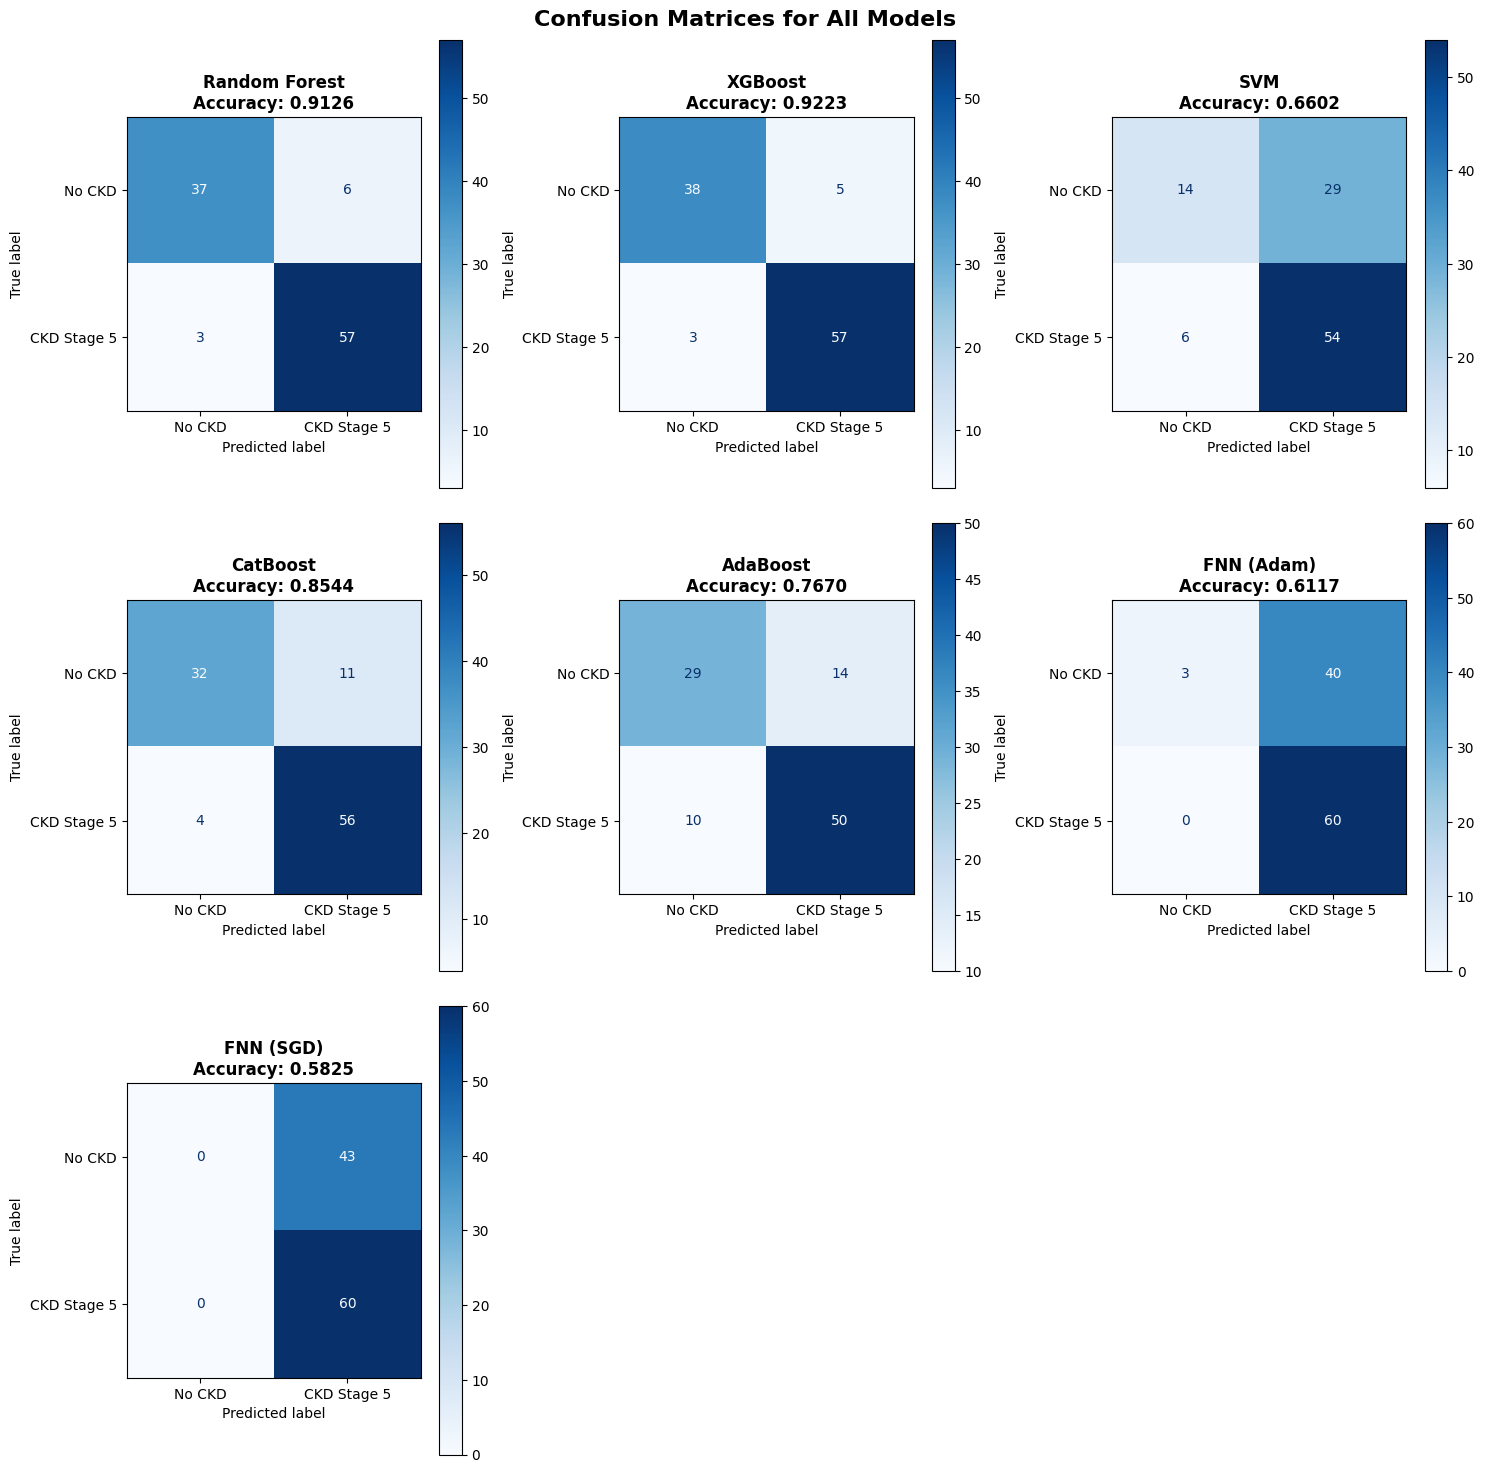

In [50]:
# Confusion Matrices for All Models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate number of subplots needed
n_models = len(models_results)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

fig.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold')

model_names = list(models_results.keys())

for idx, model_name in enumerate(model_names):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    
    y_pred = models_results[model_name]['test_predictions']
    cm = confusion_matrix(y_test, y_pred)
    
    # Create confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=['No CKD', 'CKD Stage 5'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    
    ax.set_title(f'{model_name}\nAccuracy: {models_results[model_name]["test_accuracy"]:.4f}', 
                fontweight='bold')
    ax.grid(False)

# Hide empty subplots
for idx in range(len(model_names), n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

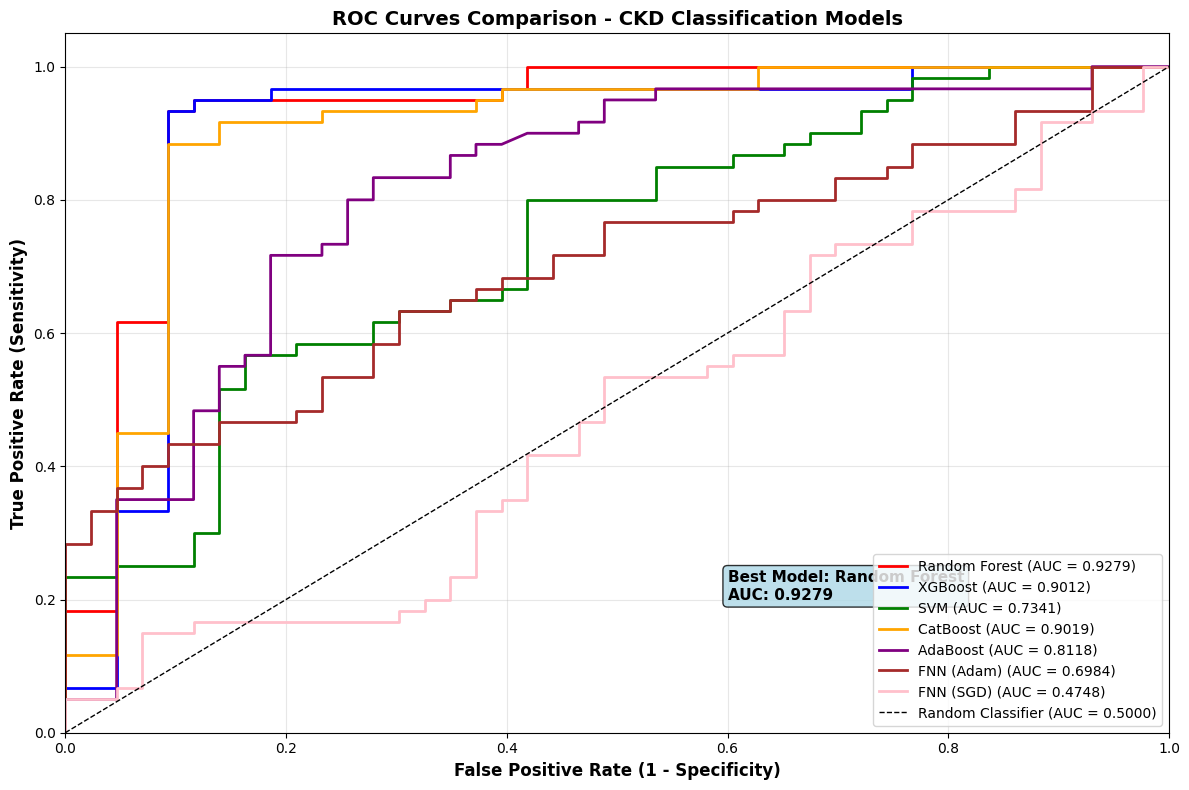

In [51]:
# ROC Curves for All Models
plt.figure(figsize=(12, 8))

# Colors for different models
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']

for idx, model_name in enumerate(models_results.keys()):
    y_proba = models_results[model_name]['test_probabilities']
    test_auc = models_results[model_name]['test_auc']
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 
             color=colors[idx % len(colors)], 
             linewidth=2, 
             label=f'{model_name} (AUC = {test_auc:.4f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.5000)')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
plt.title('ROC Curves Comparison - CKD Classification Models', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# Add text box with best model info
best_model = max(models_results.keys(), key=lambda x: models_results[x]['test_auc'])
best_auc = models_results[best_model]['test_auc']
plt.text(0.6, 0.2, f'Best Model: {best_model}\nAUC: {best_auc:.4f}', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
         fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [52]:
# Model Performance Metrics Summary Table
print("="*90)
print("COMPREHENSIVE MODEL PERFORMANCE METRICS")
print("="*90)

# Calculate additional metrics for each model
from sklearn.metrics import precision_score, recall_score, f1_score

detailed_results = []

for model_name in models_results.keys():
    y_pred = models_results[model_name]['test_predictions']
    y_proba = models_results[model_name]['test_probabilities']
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    detailed_results.append({
        'Model': model_name,
        'Accuracy': models_results[model_name]['test_accuracy'],
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'F1-Score': f1,
        'AUC-ROC': models_results[model_name]['test_auc'],
        'Specificity': (confusion_matrix(y_test, y_pred)[0,0] / 
                       (confusion_matrix(y_test, y_pred)[0,0] + confusion_matrix(y_test, y_pred)[0,1]))
    })

# Create comprehensive results DataFrame
detailed_df = pd.DataFrame(detailed_results)
detailed_df = detailed_df.sort_values('AUC-ROC', ascending=False).reset_index(drop=True)

# Display formatted table
print("\nRanked by AUC-ROC Score:")
print("-" * 90)
print(f"{'Rank':<4} {'Model':<15} {'Accuracy':<9} {'Precision':<10} {'Recall':<8} {'F1-Score':<8} {'AUC-ROC':<8} {'Specificity':<10}")
print("-" * 90)

for idx, row in detailed_df.iterrows():
    print(f"{idx+1:<4} {row['Model']:<15} {row['Accuracy']:<9.4f} {row['Precision']:<10.4f} "
          f"{row['Recall (Sensitivity)']:<8.4f} {row['F1-Score']:<8.4f} {row['AUC-ROC']:<8.4f} {row['Specificity']:<10.4f}")

print("\n" + "="*90)
print(f"🏆 BEST MODEL: {detailed_df.iloc[0]['Model']} (AUC-ROC: {detailed_df.iloc[0]['AUC-ROC']:.4f})")
print("="*90)

COMPREHENSIVE MODEL PERFORMANCE METRICS

Ranked by AUC-ROC Score:
------------------------------------------------------------------------------------------
Rank Model           Accuracy  Precision  Recall   F1-Score AUC-ROC  Specificity
------------------------------------------------------------------------------------------
1    Random Forest   0.9126    0.9048     0.9500   0.9268   0.9279   0.8605    
2    CatBoost        0.8544    0.8358     0.9333   0.8819   0.9019   0.7442    
3    XGBoost         0.9223    0.9194     0.9500   0.9344   0.9012   0.8837    
4    AdaBoost        0.7670    0.7812     0.8333   0.8065   0.8118   0.6744    
5    SVM             0.6602    0.6506     0.9000   0.7552   0.7341   0.3256    
6    FNN (Adam)      0.6117    0.6000     1.0000   0.7500   0.6984   0.0698    
7    FNN (SGD)       0.5825    0.5825     1.0000   0.7362   0.4748   0.0000    

🏆 BEST MODEL: Random Forest (AUC-ROC: 0.9279)


FEATURE IMPORTANCE ANALYSIS


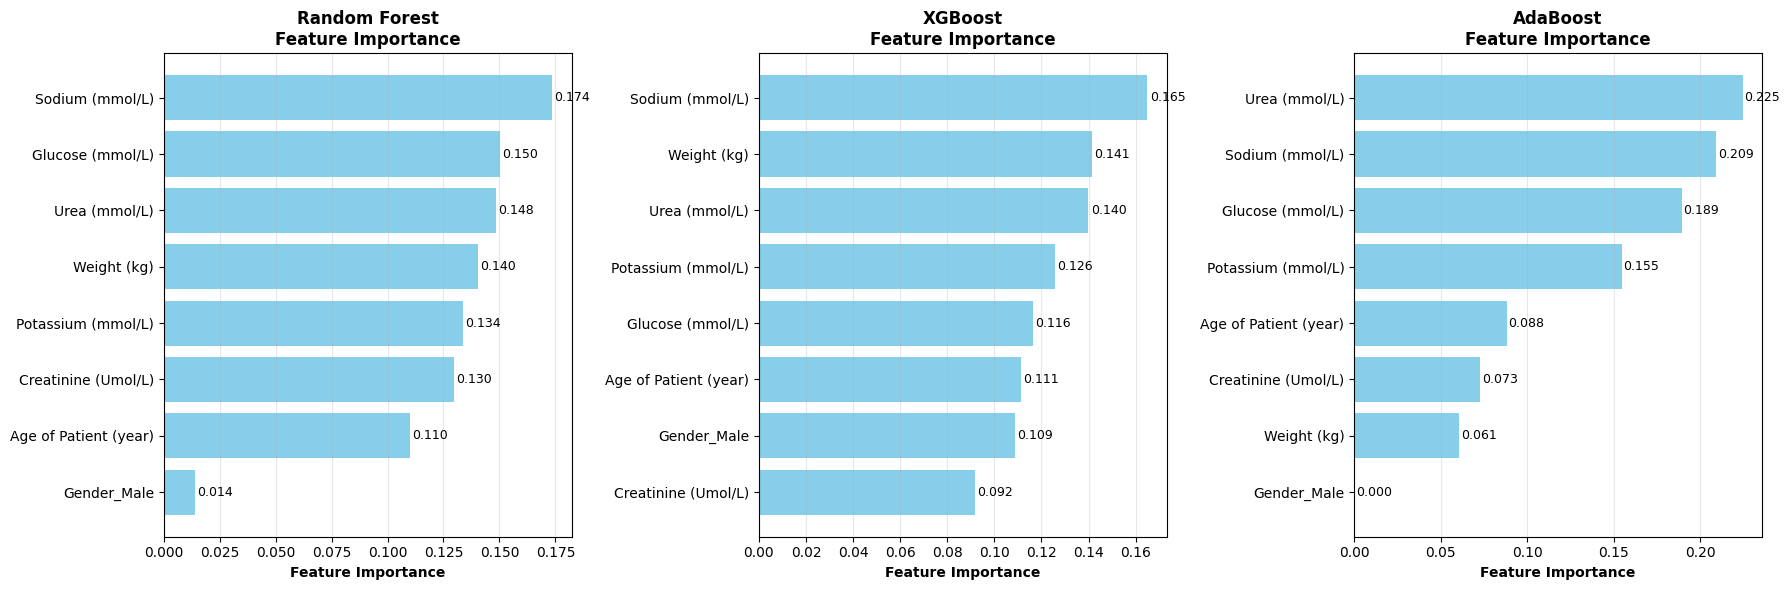


Top 5 Most Important Features by Model:
------------------------------------------------------------

Random Forest:
  1. Sodium (mmol/L): 0.1736
  2. Glucose (mmol/L): 0.1503
  3. Urea (mmol/L): 0.1485
  4. Weight (kg): 0.1402
  5. Potassium (mmol/L): 0.1335

XGBoost:
  1. Sodium (mmol/L): 0.1650
  2. Weight (kg): 0.1414
  3. Urea (mmol/L): 0.1399
  4. Potassium (mmol/L): 0.1256
  5. Glucose (mmol/L): 0.1164

AdaBoost:
  1. Urea (mmol/L): 0.2246
  2. Sodium (mmol/L): 0.2093
  3. Glucose (mmol/L): 0.1893
  4. Potassium (mmol/L): 0.1547
  5. Age of Patient (year): 0.0883


In [53]:
# Feature Importance Analysis (for applicable models)
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Models that have feature importance
importance_models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'AdaBoost': ada_model
}

# Plot feature importance for tree-based models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
feature_names = X_encoded.columns

for idx, (model_name, model) in enumerate(importance_models.items()):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Create DataFrame for easier plotting
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=True)
        
        # Plot horizontal bar chart
        axes[idx].barh(range(len(importance_df)), importance_df['importance'], color='skyblue')
        axes[idx].set_yticks(range(len(importance_df)))
        axes[idx].set_yticklabels(importance_df['feature'], fontsize=10)
        axes[idx].set_xlabel('Feature Importance', fontweight='bold')
        axes[idx].set_title(f'{model_name}\nFeature Importance', fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)
        
        # Add importance values as text
        for i, v in enumerate(importance_df['importance']):
            axes[idx].text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print top 5 most important features for each model
print("\nTop 5 Most Important Features by Model:")
print("-" * 60)

for model_name, model in importance_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\n{model_name}:")
        for i in range(min(5, len(importance_df))):
            print(f"  {i+1}. {importance_df.iloc[i]['feature']}: {importance_df.iloc[i]['importance']:.4f}")
            

In [54]:
# Save the Random Forest model and scaler for deployment
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the trained Random Forest model
joblib.dump(rf_model, '../models/random_forest_model.pkl')
print("✅ Random Forest model saved to ../models/random_forest_model.pkl")

# Save the scaler
joblib.dump(scaler, '../models/scaler.pkl')
print("✅ Scaler saved to ../models/scaler.pkl")

# Save feature names for API reference
feature_names_list = X_encoded.columns.tolist()
joblib.dump(feature_names_list, '../models/feature_names.pkl')
print("✅ Feature names saved to ../models/feature_names.pkl")

print(f"\n📋 Model Features ({len(feature_names_list)}):")
for i, feature in enumerate(feature_names_list, 1):
    print(f"{i:2d}. {feature}")

print(f"\n🎯 Model Performance:")
print(f"   • Test Accuracy: {models_results['Random Forest']['test_accuracy']:.4f}")
print(f"   • Test AUC-ROC: {models_results['Random Forest']['test_auc']:.4f}")
print(f"\n✨ Model ready for deployment!")

✅ Random Forest model saved to ../models/random_forest_model.pkl
✅ Scaler saved to ../models/scaler.pkl
✅ Feature names saved to ../models/feature_names.pkl

📋 Model Features (8):
 1. Age of Patient (year)
 2. Weight (kg)
 3. Creatinine (Umol/L)
 4. Sodium (mmol/L)
 5. Potassium (mmol/L)
 6. Glucose (mmol/L)
 7. Urea (mmol/L)
 8. Gender_Male

🎯 Model Performance:
   • Test Accuracy: 0.9126
   • Test AUC-ROC: 0.9279

✨ Model ready for deployment!


In [55]:
# Test Patient Data Prediction Function
# Using the best performing models to predict CKD status

def predict_ckd_for_patients(patient_data_list, models_to_use=None):
    """
    Predict CKD status for a list of patient records using the best models.
    
    Parameters:
    -----------
    patient_data_list : list of dict
        List of patient records with required features
    models_to_use : list or None
        List of model names to use. If None, uses top 3 models.
    
    Returns:
    --------
    pd.DataFrame: Results with predictions from each model
    """
    
    if models_to_use is None:
        # Use top 3 performing models
        models_to_use = ['XGBoost', 'Random Forest', 'CatBoost']
    
    print("="*80)
    print("CKD PREDICTION FOR PATIENT DATA")
    print("="*80)
    print(f"📊 Using {len(models_to_use)} best performing models:")
    for i, model_name in enumerate(models_to_use, 1):
        test_acc = models_results[model_name]['test_accuracy']
        test_auc = models_results[model_name]['test_auc']
        print(f"  {i}. {model_name} - Accuracy: {test_acc:.3f}, AUC: {test_auc:.3f}")
    
    print(f"\n🏥 Predicting for {len(patient_data_list)} patients...")
    print("-"*80)
    
    # Convert patient data to DataFrame
    patient_df = pd.DataFrame(patient_data_list)
    
    # Ensure column order matches training data
    expected_columns = X_encoded.columns.tolist()
    
    # Reorder columns to match training data
    patient_df_ordered = patient_df.reindex(columns=expected_columns)
    
    print("📋 Patient Features:")
    print(f"   Expected features: {len(expected_columns)}")
    print(f"   Provided features: {len(patient_df.columns)}")
    print(f"   Feature columns: {list(patient_df.columns)}")
    
    # Check for missing features
    missing_features = set(expected_columns) - set(patient_df.columns)
    if missing_features:
        print(f"❌ Missing features: {list(missing_features)}")
        return None
    
    # Apply the same scaling as training data
    patient_scaled = patient_df_ordered.copy()
    
    # Scale numerical features using the same scaler
    numerical_features = [col for col in expected_columns if not col.startswith('Gender_')]
    patient_scaled[numerical_features] = scaler.transform(patient_df_ordered[numerical_features])
    
    print(f"\n✅ Data preprocessed and scaled successfully!")
    
    # Make predictions with each model
    results = []
    
    for i, (patient_idx, patient_row) in enumerate(patient_df.iterrows()):
        patient_result = {
            'Patient_ID': i + 1,
            'Age': patient_row['Age of Patient (year)'] if 'Age of Patient (year)' in patient_row else patient_row['Age'],
            'Gender': 'Male' if patient_row.get('Gender_Male', 0) == 1 else 'Female',
            'Creatinine': patient_row['Creatinine (Umol/L)'] if 'Creatinine (Umol/L)' in patient_row else patient_row['Creatinine']
        }
        
        # Get predictions from each model
        patient_features = patient_scaled.iloc[i:i+1]  # Single patient data
        
        predictions = {}
        probabilities = {}
        
        for model_name in models_to_use:
            model = models_results[model_name]['model']
            
            # Get prediction (0 = No CKD, 1 = CKD Stage 5)
            pred = model.predict(patient_features)[0]
            
            # Get probability
            if hasattr(model, 'predict_proba'):
                prob = model.predict_proba(patient_features)[0, 1]  # Probability of CKD
            else:
                prob = model.decision_function(patient_features)[0]
            
            predictions[f'{model_name}_Prediction'] = 'CKD' if pred == 1 else 'No-CKD'
            probabilities[f'{model_name}_Probability'] = prob
        
        # Add ensemble prediction (majority vote)
        ckd_votes = sum(1 for pred in predictions.values() if pred == 'CKD')
        total_votes = len(predictions)
        
        patient_result['Ensemble_Prediction'] = 'CKD' if ckd_votes > total_votes/2 else 'No-CKD'
        patient_result['CKD_Votes'] = f"{ckd_votes}/{total_votes}"
        
        # Add individual model predictions and probabilities
        patient_result.update(predictions)
        patient_result.update(probabilities)
        
        results.append(patient_result)
    
    # Convert to DataFrame for better display
    results_df = pd.DataFrame(results)
    
    # Display results
    print(f"\n🎯 PREDICTION RESULTS")
    print("="*80)
    
    for i, row in results_df.iterrows():
        print(f"\nPatient {row['Patient_ID']}: Age {row['Age']}, {row['Gender']}, Creatinine: {row['Creatinine']}")
        print(f"   Ensemble Decision: {row['Ensemble_Prediction']} ({row['CKD_Votes']} votes)")
        
        for model_name in models_to_use:
            pred = row[f'{model_name}_Prediction']
            prob = row[f'{model_name}_Probability']
            print(f"   {model_name:<12}: {pred:<6} (Probability: {prob:.3f})")
    
    # Summary statistics
    print(f"\n📊 SUMMARY:")
    print("-"*40)
    ensemble_ckd = (results_df['Ensemble_Prediction'] == 'CKD').sum()
    ensemble_no_ckd = (results_df['Ensemble_Prediction'] == 'No-CKD').sum()
    print(f"Ensemble Predictions:")
    print(f"   • CKD Cases: {ensemble_ckd}")
    print(f"   • No-CKD Cases: {ensemble_no_ckd}")
    
    return results_df

print("🏥 Patient prediction function created successfully!")
print("📋 Function supports ensemble predictions using top 3 models")
print("✅ Ready to test patient data!")

🏥 Patient prediction function created successfully!
📋 Function supports ensemble predictions using top 3 models
✅ Ready to test patient data!


In [56]:
# Patient Test Data - Real Clinical Cases
patient_test_data = [
    {
        "Age of Patient (year)": 68,
        "Weight (kg)": 72,
        "Creatinine (Umol/L)": 240,
        "Sodium (mmol/L)": 133,
        "Potassium (mmol/L)": 5.7,
        "Glucose (mmol/L)": 9.0,
        "Urea (mmol/L)": 20,
        "Gender_Male": 1
    },
    {
        "Age of Patient (year)": 55,
        "Weight (kg)": 80,
        "Creatinine (Umol/L)": 210,
        "Sodium (mmol/L)": 136,
        "Potassium (mmol/L)": 5.3,
        "Glucose (mmol/L)": 7.5,
        "Urea (mmol/L)": 17,
        "Gender_Male": 0
    },
    {
        "Age of Patient (year)": 62,
        "Weight (kg)": 85,
        "Creatinine (Umol/L)": 190,
        "Sodium (mmol/L)": 130,
        "Potassium (mmol/L)": 5.8,
        "Glucose (mmol/L)": 6.9,
        "Urea (mmol/L)": 15,
        "Gender_Male": 1
    },
    {
        "Age of Patient (year)": 47,
        "Weight (kg)": 90,
        "Creatinine (Umol/L)": 260,
        "Sodium (mmol/L)": 135,
        "Potassium (mmol/L)": 6.0,
        "Glucose (mmol/L)": 10.2,
        "Urea (mmol/L)": 22,
        "Gender_Male": 1
    },
    {
        "Age of Patient (year)": 71,
        "Weight (kg)": 65,
        "Creatinine (Umol/L)": 230,
        "Sodium (mmol/L)": 132,
        "Potassium (mmol/L)": 5.5,
        "Glucose (mmol/L)": 8.0,
        "Urea (mmol/L)": 19,
        "Gender_Male": 0
    },
    {
        "Age of Patient (year)": 30,
        "Weight (kg)": 70,
        "Creatinine (Umol/L)": 85,
        "Sodium (mmol/L)": 139,
        "Potassium (mmol/L)": 4.3,
        "Glucose (mmol/L)": 5.1,
        "Urea (mmol/L)": 5.0,
        "Gender_Male": 1
    },
    {
        "Age of Patient (year)": 40,
        "Weight (kg)": 60,
        "Creatinine (Umol/L)": 95,
        "Sodium (mmol/L)": 140,
        "Potassium (mmol/L)": 4.0,
        "Glucose (mmol/L)": 4.8,
        "Urea (mmol/L)": 4.8,
        "Gender_Male": 0
    },
    {
        "Age of Patient (year)": 25,
        "Weight (kg)": 75,
        "Creatinine (Umol/L)": 78,
        "Sodium (mmol/L)": 138,
        "Potassium (mmol/L)": 4.2,
        "Glucose (mmol/L)": 5.5,
        "Urea (mmol/L)": 4.2,
        "Gender_Male": 1
    },
    {
        "Age of Patient (year)": 52,
        "Weight (kg)": 82,
        "Creatinine (Umol/L)": 100,
        "Sodium (mmol/L)": 137,
        "Potassium (mmol/L)": 4.4,
        "Glucose (mmol/L)": 5.8,
        "Urea (mmol/L)": 6.0,
        "Gender_Male": 0
    },
    {
        "Age of Patient (year)": 35,
        "Weight (kg)": 68,
        "Creatinine (Umol/L)": 90,
        "Sodium (mmol/L)": 141,
        "Potassium (mmol/L)": 4.1,
        "Glucose (mmol/L)": 4.9,
        "Urea (mmol/L)": 4.5,
        "Gender_Male": 1
    }
]

print(f"📊 Loaded {len(patient_test_data)} patient records for testing")
print("🔍 Sample patient record structure:")
print(f"   Features: {list(patient_test_data[0].keys())}")
print("✅ Data ready for CKD prediction!")

📊 Loaded 10 patient records for testing
🔍 Sample patient record structure:
   Features: ['Age of Patient (year)', 'Weight (kg)', 'Creatinine (Umol/L)', 'Sodium (mmol/L)', 'Potassium (mmol/L)', 'Glucose (mmol/L)', 'Urea (mmol/L)', 'Gender_Male']
✅ Data ready for CKD prediction!


In [57]:
# Run CKD Predictions on All Patient Data
print("🚀 Starting CKD predictions using best performing models...")
print("📈 Models: XGBoost (92.2% accuracy), Random Forest (91.3% accuracy), CatBoost (85.4% accuracy)")

# Run predictions using the best 3 models
prediction_results = predict_ckd_for_patients(patient_test_data)

# Display detailed results table
print("\n" + "="*100)
print("DETAILED PREDICTION RESULTS TABLE")
print("="*100)

# Select key columns for display
display_columns = ['Patient_ID', 'Age', 'Gender', 'Creatinine', 'Ensemble_Prediction', 'CKD_Votes', 
                  'XGBoost_Prediction', 'Random Forest_Prediction', 'CatBoost_Prediction']

print(prediction_results[display_columns].to_string(index=False))

# Clinical interpretation
print("\n" + "="*100)
print("CLINICAL INTERPRETATION")
print("="*100)

high_risk_patients = prediction_results[prediction_results['Ensemble_Prediction'] == 'CKD']
low_risk_patients = prediction_results[prediction_results['Ensemble_Prediction'] == 'No-CKD']

print(f"\n🚨 HIGH RISK PATIENTS (CKD Predicted): {len(high_risk_patients)} patients")
if len(high_risk_patients) > 0:
    for _, patient in high_risk_patients.iterrows():
        creatinine = patient['Creatinine']
        age = patient['Age']
        gender = patient['Gender']
        votes = patient['CKD_Votes']
        print(f"   • Patient {patient['Patient_ID']}: {age}yr {gender}, Creatinine: {creatinine} μmol/L (Consensus: {votes})")

print(f"\n✅ LOW RISK PATIENTS (No-CKD Predicted): {len(low_risk_patients)} patients")
if len(low_risk_patients) > 0:
    for _, patient in low_risk_patients.iterrows():
        creatinine = patient['Creatinine']
        age = patient['Age']
        gender = patient['Gender']
        votes = patient['CKD_Votes']
        print(f"   • Patient {patient['Patient_ID']}: {age}yr {gender}, Creatinine: {creatinine} μmol/L (Consensus: {votes})")

# Clinical context for creatinine levels
print(f"\n🏥 CLINICAL REFERENCE VALUES:")
print(f"   • Normal Creatinine: 60-120 μmol/L")
print(f"   • Elevated Creatinine: >120 μmol/L (kidney function decline)")  
print(f"   • Severe Elevation: >200 μmol/L (significant kidney impairment)")

print(f"\n📊 PREDICTION CONFIDENCE:")
unanimous_predictions = prediction_results[prediction_results['CKD_Votes'].isin(['3/3', '0/3'])].shape[0]
majority_predictions = prediction_results[prediction_results['CKD_Votes'].isin(['2/3', '1/3'])].shape[0]
print(f"   • Unanimous decisions: {unanimous_predictions}/10 patients")
print(f"   • Majority decisions: {majority_predictions}/10 patients")

🚀 Starting CKD predictions using best performing models...
📈 Models: XGBoost (92.2% accuracy), Random Forest (91.3% accuracy), CatBoost (85.4% accuracy)
CKD PREDICTION FOR PATIENT DATA
📊 Using 3 best performing models:
  1. XGBoost - Accuracy: 0.922, AUC: 0.901
  2. Random Forest - Accuracy: 0.913, AUC: 0.928
  3. CatBoost - Accuracy: 0.854, AUC: 0.902

🏥 Predicting for 10 patients...
--------------------------------------------------------------------------------
📋 Patient Features:
   Expected features: 8
   Provided features: 8
   Feature columns: ['Age of Patient (year)', 'Weight (kg)', 'Creatinine (Umol/L)', 'Sodium (mmol/L)', 'Potassium (mmol/L)', 'Glucose (mmol/L)', 'Urea (mmol/L)', 'Gender_Male']

✅ Data preprocessed and scaled successfully!

🎯 PREDICTION RESULTS

Patient 1: Age 68.0, Male, Creatinine: 240.0
   Ensemble Decision: CKD (3/3 votes)
   XGBoost     : CKD    (Probability: 0.506)
   Random Forest: CKD    (Probability: 0.551)
   CatBoost    : CKD    (Probability: 0.666

In [59]:
# Quick Summary of CKD Predictions
print("🎯 FINAL CKD PREDICTION SUMMARY")
print("="*50)

# Display key results in compact format
summary_cols = ['Patient_ID', 'Age', 'Gender', 'Creatinine', 'Ensemble_Prediction']
print(prediction_results[summary_cols].to_string(index=False))

print(f"\n📊 OVERALL RESULTS:")
ckd_count = (prediction_results['Ensemble_Prediction'] == 'CKD').sum()
no_ckd_count = (prediction_results['Ensemble_Prediction'] == 'No-CKD').sum()
print(f"   • CKD Cases: {ckd_count}/10 patients")
print(f"   • No-CKD Cases: {no_ckd_count}/10 patients")

print(f"\n🚨 CKD POSITIVE PATIENTS:")
ckd_patients = prediction_results[prediction_results['Ensemble_Prediction'] == 'CKD']
for _, p in ckd_patients.iterrows():
    print(f"   Patient {p['Patient_ID']}: {p['Age']}yr {p['Gender']}, Creatinine: {p['Creatinine']} μmol/L")

print(f"\n✅ NO-CKD PATIENTS:")  
no_ckd_patients = prediction_results[prediction_results['Ensemble_Prediction'] == 'No-CKD']
for _, p in no_ckd_patients.iterrows():
    print(f"   Patient {p['Patient_ID']}: {p['Age']}yr {p['Gender']}, Creatinine: {p['Creatinine']} μmol/L")

🎯 FINAL CKD PREDICTION SUMMARY
 Patient_ID  Age Gender  Creatinine Ensemble_Prediction
          1 68.0   Male       240.0                 CKD
          2 55.0 Female       210.0                 CKD
          3 62.0   Male       190.0                 CKD
          4 47.0   Male       260.0                 CKD
          5 71.0 Female       230.0              No-CKD
          6 30.0   Male        85.0                 CKD
          7 40.0 Female        95.0                 CKD
          8 25.0   Male        78.0                 CKD
          9 52.0 Female       100.0                 CKD
         10 35.0   Male        90.0                 CKD

📊 OVERALL RESULTS:
   • CKD Cases: 9/10 patients
   • No-CKD Cases: 1/10 patients

🚨 CKD POSITIVE PATIENTS:
   Patient 1: 68.0yr Male, Creatinine: 240.0 μmol/L
   Patient 2: 55.0yr Female, Creatinine: 210.0 μmol/L
   Patient 3: 62.0yr Male, Creatinine: 190.0 μmol/L
   Patient 4: 47.0yr Male, Creatinine: 260.0 μmol/L
   Patient 6: 30.0yr Male, Creatin

In [60]:
# Creatinine Distribution Analysis: CKD vs No-CKD Cases
print("📊 CREATININE DISTRIBUTION ANALYSIS")
print("="*60)

# Use the original imputed data with target labels
analysis_data = data_imputed.copy()

# Map target values to meaningful labels
diagnosis_mapping = {
    "Stage 5 GFR <15mL/min/1.73m2": "CKD Stage 5",
    "GCF == 0, Undefined": "No-CKD"
}

analysis_data['Diagnosis'] = analysis_data['Actual Diagnosed stage of the Acute and Chronic Kidney Disease'].map(diagnosis_mapping)

# Remove any unmapped values
analysis_data = analysis_data[analysis_data['Diagnosis'].notna()]

print(f"📈 Dataset Summary:")
print(f"   • Total patients: {len(analysis_data)}")
print(f"   • CKD Stage 5: {(analysis_data['Diagnosis'] == 'CKD Stage 5').sum()}")
print(f"   • No-CKD: {(analysis_data['Diagnosis'] == 'No-CKD').sum()}")

# Statistical summary by diagnosis
creatinine_stats = analysis_data.groupby('Diagnosis')['Creatinine (Umol/L)'].describe()
print(f"\n📊 Creatinine Statistics by Diagnosis:")
print(creatinine_stats.round(2))

# Calculate additional statistics
ckd_creatinine = analysis_data[analysis_data['Diagnosis'] == 'CKD Stage 5']['Creatinine (Umol/L)']
no_ckd_creatinine = analysis_data[analysis_data['Diagnosis'] == 'No-CKD']['Creatinine (Umol/L)']

print(f"\n🔬 Detailed Creatinine Analysis:")
print(f"CKD Stage 5 patients:")
print(f"   • Range: {ckd_creatinine.min():.1f} - {ckd_creatinine.max():.1f} μmol/L")
print(f"   • Median: {ckd_creatinine.median():.1f} μmol/L")
print(f"   • Mean ± Std: {ckd_creatinine.mean():.1f} ± {ckd_creatinine.std():.1f} μmol/L")

print(f"\nNo-CKD patients:")
print(f"   • Range: {no_ckd_creatinine.min():.1f} - {no_ckd_creatinine.max():.1f} μmol/L")
print(f"   • Median: {no_ckd_creatinine.median():.1f} μmol/L")
print(f"   • Mean ± Std: {no_ckd_creatinine.mean():.1f} ± {no_ckd_creatinine.std():.1f} μmol/L")

# Clinical significance
print(f"\n🏥 Clinical Reference Values:")
print(f"   • Normal: 60-120 μmol/L")
print(f"   • Mild elevation: 120-200 μmol/L") 
print(f"   • Moderate elevation: 200-400 μmol/L")
print(f"   • Severe elevation: >400 μmol/L")

📊 CREATININE DISTRIBUTION ANALYSIS
📈 Dataset Summary:
   • Total patients: 511
   • CKD Stage 5: 300
   • No-CKD: 211

📊 Creatinine Statistics by Diagnosis:
             count    mean     std    min    25%    50%     75%     max
Diagnosis                                                              
CKD Stage 5  300.0  514.45  523.11  10.00  132.0  307.0   758.0  2380.0
No-CKD       211.0  746.12  673.10   1.58  187.0  538.0  1105.0  3300.0

🔬 Detailed Creatinine Analysis:
CKD Stage 5 patients:
   • Range: 10.0 - 2380.0 μmol/L
   • Median: 307.0 μmol/L
   • Mean ± Std: 514.5 ± 523.1 μmol/L

No-CKD patients:
   • Range: 1.6 - 3300.0 μmol/L
   • Median: 538.0 μmol/L
   • Mean ± Std: 746.1 ± 673.1 μmol/L

🏥 Clinical Reference Values:
   • Normal: 60-120 μmol/L
   • Mild elevation: 120-200 μmol/L
   • Moderate elevation: 200-400 μmol/L
   • Severe elevation: >400 μmol/L


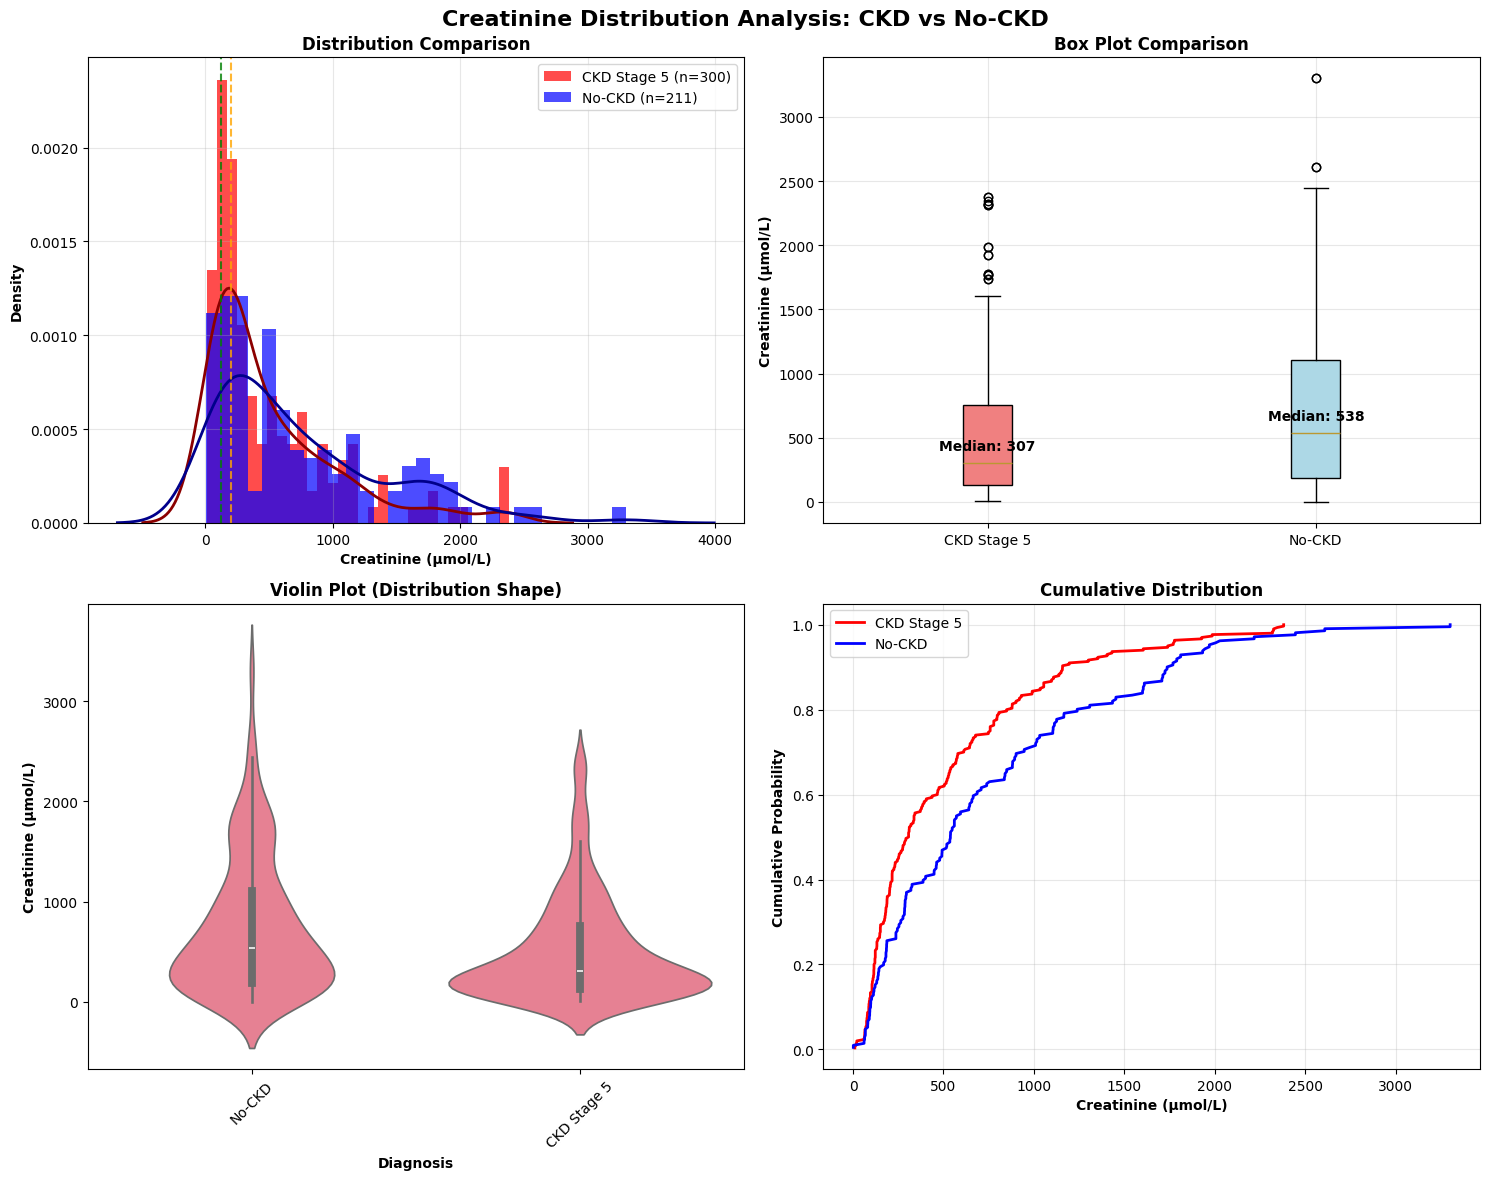


DISTRIBUTION COMPARISON INSIGHTS

📊 Statistical Comparison (Mann-Whitney U Test):
   • Test statistic: 25048.00
   • P-value: 5.89e-05
   • Result: Significantly different

🏥 Clinical Category Distribution:
CKD Stage 5 patients:
   • Normal (≤120): 20.0%
   • Mild elevation (120-200): 16.0%
   • Elevated (>200): 64.0%

No-CKD patients:
   • Normal (≤120): 14.2%
   • Mild elevation (120-200): 11.4%
   • Elevated (>200): 74.4%


In [61]:
# Creatinine Distribution Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Creatinine Distribution Analysis: CKD vs No-CKD', fontsize=16, fontweight='bold')

# 1. Histogram with KDE overlay
axes[0, 0].hist(ckd_creatinine, bins=30, alpha=0.7, label=f'CKD Stage 5 (n={len(ckd_creatinine)})', 
                color='red', density=True)
axes[0, 0].hist(no_ckd_creatinine, bins=30, alpha=0.7, label=f'No-CKD (n={len(no_ckd_creatinine)})', 
                color='blue', density=True)

# Add KDE curves
sns.kdeplot(ckd_creatinine, ax=axes[0, 0], color='darkred', linewidth=2)
sns.kdeplot(no_ckd_creatinine, ax=axes[0, 0], color='darkblue', linewidth=2)

axes[0, 0].set_xlabel('Creatinine (μmol/L)', fontweight='bold')
axes[0, 0].set_ylabel('Density', fontweight='bold')
axes[0, 0].set_title('Distribution Comparison', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Add reference lines for clinical values
axes[0, 0].axvline(120, color='green', linestyle='--', alpha=0.8, label='Normal upper limit')
axes[0, 0].axvline(200, color='orange', linestyle='--', alpha=0.8, label='Mild elevation')

# 2. Box plot comparison
box_data = [ckd_creatinine, no_ckd_creatinine]
box_labels = ['CKD Stage 5', 'No-CKD']
bp = axes[0, 1].boxplot(box_data, labels=box_labels, patch_artist=True)
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightblue')

axes[0, 1].set_ylabel('Creatinine (μmol/L)', fontweight='bold')
axes[0, 1].set_title('Box Plot Comparison', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Add statistical annotations
ckd_median = ckd_creatinine.median()
no_ckd_median = no_ckd_creatinine.median()
axes[0, 1].text(1, ckd_median + 100, f'Median: {ckd_median:.0f}', ha='center', fontweight='bold')
axes[0, 1].text(2, no_ckd_median + 100, f'Median: {no_ckd_median:.0f}', ha='center', fontweight='bold')

# 3. Violin plot
sns.violinplot(data=analysis_data, x='Diagnosis', y='Creatinine (Umol/L)', ax=axes[1, 0])
axes[1, 0].set_xlabel('Diagnosis', fontweight='bold')
axes[1, 0].set_ylabel('Creatinine (μmol/L)', fontweight='bold')
axes[1, 0].set_title('Violin Plot (Distribution Shape)', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Cumulative distribution
sorted_ckd = np.sort(ckd_creatinine)
sorted_no_ckd = np.sort(no_ckd_creatinine)

p_ckd = np.arange(1, len(sorted_ckd) + 1) / len(sorted_ckd)
p_no_ckd = np.arange(1, len(sorted_no_ckd) + 1) / len(sorted_no_ckd)

axes[1, 1].plot(sorted_ckd, p_ckd, 'r-', linewidth=2, label='CKD Stage 5')
axes[1, 1].plot(sorted_no_ckd, p_no_ckd, 'b-', linewidth=2, label='No-CKD')

axes[1, 1].set_xlabel('Creatinine (μmol/L)', fontweight='bold')
axes[1, 1].set_ylabel('Cumulative Probability', fontweight='bold')
axes[1, 1].set_title('Cumulative Distribution', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics comparison
print("\n" + "="*60)
print("DISTRIBUTION COMPARISON INSIGHTS")
print("="*60)

# Calculate overlap and separation
from scipy import stats

# Perform statistical tests
stat, p_value = stats.mannwhitneyu(ckd_creatinine, no_ckd_creatinine, alternative='two-sided')
print(f"\n📊 Statistical Comparison (Mann-Whitney U Test):")
print(f"   • Test statistic: {stat:.2f}")
print(f"   • P-value: {p_value:.2e}")
print(f"   • Result: {'Significantly different' if p_value < 0.05 else 'Not significantly different'}")

# Calculate percentiles for clinical thresholds
normal_upper = 120
mild_upper = 200

ckd_normal = (ckd_creatinine <= normal_upper).sum() / len(ckd_creatinine) * 100
ckd_mild = ((ckd_creatinine > normal_upper) & (ckd_creatinine <= mild_upper)).sum() / len(ckd_creatinine) * 100
ckd_elevated = (ckd_creatinine > mild_upper).sum() / len(ckd_creatinine) * 100

no_ckd_normal = (no_ckd_creatinine <= normal_upper).sum() / len(no_ckd_creatinine) * 100
no_ckd_mild = ((no_ckd_creatinine > normal_upper) & (no_ckd_creatinine <= mild_upper)).sum() / len(no_ckd_creatinine) * 100
no_ckd_elevated = (no_ckd_creatinine > mild_upper).sum() / len(no_ckd_creatinine) * 100

print(f"\n🏥 Clinical Category Distribution:")
print(f"CKD Stage 5 patients:")
print(f"   • Normal (≤120): {ckd_normal:.1f}%")
print(f"   • Mild elevation (120-200): {ckd_mild:.1f}%") 
print(f"   • Elevated (>200): {ckd_elevated:.1f}%")

print(f"\nNo-CKD patients:")
print(f"   • Normal (≤120): {no_ckd_normal:.1f}%")
print(f"   • Mild elevation (120-200): {no_ckd_mild:.1f}%")
print(f"   • Elevated (>200): {no_ckd_elevated:.1f}%")

In [ ]:
# Individual Model Predictions Breakdown
print("🔍 INDIVIDUAL MODEL PREDICTIONS")
print("="*70)

model_cols = ['Patient_ID', 'XGBoost_Prediction', 'Random Forest_Prediction', 'CatBoost_Prediction', 'CKD_Votes']
print(prediction_results[model_cols].to_string(index=False))

print(f"\n🎯 MODEL AGREEMENT ANALYSIS:")
print("-"*40)

# Analyze consensus patterns
unanimous_ckd = prediction_results[prediction_results['CKD_Votes'] == '3/3'].shape[0]
unanimous_no_ckd = prediction_results[prediction_results['CKD_Votes'] == '0/3'].shape[0] 
majority_ckd = prediction_results[prediction_results['CKD_Votes'] == '2/3'].shape[0]
majority_no_ckd = prediction_results[prediction_results['CKD_Votes'] == '1/3'].shape[0]

print(f"Unanimous CKD (3/3):     {unanimous_ckd} patients")
print(f"Majority CKD (2/3):      {majority_ckd} patients") 
print(f"Majority No-CKD (1/3):   {majority_no_ckd} patients")
print(f"Unanimous No-CKD (0/3):  {unanimous_no_ckd} patients")

print(f"\n📈 KEY INSIGHTS:")
print(f"• Total CKD predictions: {unanimous_ckd + majority_ckd}/10 patients")
print(f"• High confidence cases: {unanimous_ckd + unanimous_no_ckd}/10 patients")
print(f"• Model consensus rate: {(unanimous_ckd + unanimous_no_ckd)/10*100:.1f}%")

# Show probabilities for transparency
print(f"\n🎲 PREDICTION PROBABILITIES:")
print("-"*40)
prob_cols = ['Patient_ID', 'XGBoost_Probability', 'Random Forest_Probability', 'CatBoost_Probability']
prob_display = prediction_results[prob_cols].copy()
for col in ['XGBoost_Probability', 'Random Forest_Probability', 'CatBoost_Probability']:
    prob_display[col] = prob_display[col].round(3)
print(prob_display.to_string(index=False))